### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#D68910"> MRA Milestone 1 Project - Auto Spare parts Sales Data - RFM Segmentation

#### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#424949"> An automobile parts manufacturing company has collected data of transactions for 3 years. They do not have any in-house data science team, thus they have hired you as their consultant. Your job is to use your magical data science skills to provide them with suitable insights about their data and their customers.

### <span style="font-family: Arial; font-weight:bold;font-size:1em;color:#D68910"> Data Dictionary

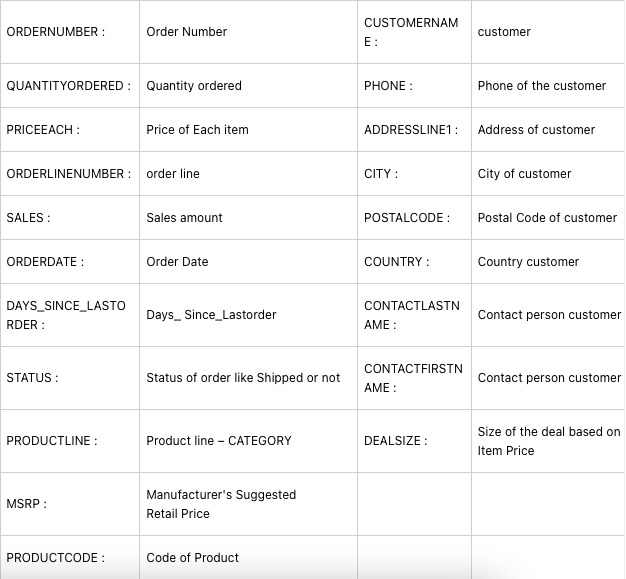

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Import Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore                                        # ZSCORE SCALING
from sklearn.preprocessing import StandardScaler                 # ZScore

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, centroid          # HIERARCHICAL CLUSTERING 
from sklearn.cluster import KMeans                                    # K-MEANS CLUSTERING

from sklearn.metrics import silhouette_samples, silhouette_score      # SILHOUETTE SCORE FOR K-MEANS

from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(color_codes=True)
sns.set_palette('Accent_r')

%config InlineBackend.figure_format ='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Load and Explore Dataset

In [113]:
df = pd.read_excel('Sales_Data.xlsx')
df.head(10).to_csv('df_head.csv')
df.head(10)

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10168               36      96.66                1  3479.76   
5        10180               29      86.13                9  2497.77   
6        10188               48     114.84                1  5512.32   
7        10211               41     114.84               14  4708.44   
8        10223               37     107.18                1  3965.66   
9        10237               23     101.44                7  2333.12   

   ORDERDATE  DAYS_SINCE_LASTORDER   STATUS  PRODUCTLINE  MSRP PRODUCTCODE  \
0 2018-02-24                   828  Shipped  Motorcycles    95    S10_1678   
1 2018-05-07                   757  Shipped  Motorcycles    95    S10_1678   
2 2018-07-01                   703  Shipped  Motorcycles    95    S10_1678   
3 2018-08-25                   649  Shipped  Motorcycles    95    S10_1678   
4 2018-10-28                   586  Shipped  Motorcycles    95    S10_1678   
5 2018-11-11                   573  Shipped  Motorcycles    95    S10_1678   
6 2018-11-18                   567  Shipped  Motorcycles    95    S10_1678   
7 2019-01-15                   510  Shipped  Motorcycles    95    S10_1678   
8 2019-02-20                   475  Shipped  Motorcycles    95    S10_1678   
9 2019-04-05                   432  Shipped  Motorcycles    95    S10_1678   

                 CUSTOMERNAME             PHONE  \
0           Land of Toys Inc.        2125557818   
1          Reims Collectables        26.47.1555   
2             Lyon Souveniers  +33 1 46 62 7555   
3           Toys4GrownUps.com        6265557265   
4        Technics Stores Inc.        6505556809   
5    Daedalus Designs Imports        20.16.1555   
6                Herkku Gifts     +47 2267 3215   
7            Auto Canal Petit    (1) 47.55.6555   
8  Australian Collectors, Co.      03 9520 4555   
9             Vitachrome Inc.        2125551500   

                    ADDRESSLINE1        CITY POSTALCODE    COUNTRY  \
0        897 Long Airport Avenue         NYC      10022        USA   
1             59 rue de l'Abbaye       Reims      51100     France   
2  27 rue du Colonel Pierre Avia       Paris      75508     France   
3             78934 Hillside Dr.    Pasadena      90003        USA   
4              9408 Furth Circle  Burlingame      94217        USA   
5        184, chausse de Tournai       Lille      59000     France   
6    Drammen 121, PR 744 Sentrum      Bergen     N 5804     Norway   
7              25, rue Lauriston       Paris      75016     France   
8              636 St Kilda Road   Melbourne       3004  Australia   
9              2678 Kingston Rd.         NYC      10022        USA   

  CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0              Yu             Kwai    Small  
1         Henriot             Paul    Small  
2        Da Cunha           Daniel   Medium  
3           Young            Julie   Medium  
4          Hirano             Juri   Medium  
5           Rance          Martine    Small  
6          Oeztan           Veysel   Medium  
7         Perrier        Dominique   Medium  
8        Ferguson            Peter   Medium  
9           Frick          Michael    Small

In [114]:
df.shape

(2747, 20)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ORDERNUMBER           2747 non-null   int64         
 1   QUANTITYORDERED       2747 non-null   int64         
 2   PRICEEACH             2747 non-null   float64       
 3   ORDERLINENUMBER       2747 non-null   int64         
 4   SALES                 2747 non-null   float64       
 5   ORDERDATE             2747 non-null   datetime64[ns]
 6   DAYS_SINCE_LASTORDER  2747 non-null   int64         
 7   STATUS                2747 non-null   object        
 8   PRODUCTLINE           2747 non-null   object        
 9   MSRP                  2747 non-null   int64         
 10  PRODUCTCODE           2747 non-null   object        
 11  CUSTOMERNAME          2747 non-null   object        
 12  PHONE                 2747 non-null   object        
 13  ADDRESSLINE1      

In [116]:
df.describe().T.to_csv('df_describe_num.csv')
df.describe().T

count          mean          std       min        25%  \
ORDERNUMBER           2747.0  10259.761558    91.877521  10100.00  10181.000   
QUANTITYORDERED       2747.0     35.103021     9.762135      6.00     27.000   
PRICEEACH             2747.0    101.098951    42.042548     26.88     68.745   
ORDERLINENUMBER       2747.0      6.491081     4.230544      1.00      3.000   
SALES                 2747.0   3553.047583  1838.953901    482.13   2204.350   
DAYS_SINCE_LASTORDER  2747.0   1757.085912   819.280576     42.00   1077.000   
MSRP                  2747.0    100.691664    40.114802     33.00     68.000   

                           50%        75%       max  
ORDERNUMBER           10264.00  10334.500  10425.00  
QUANTITYORDERED          35.00     43.000     97.00  
PRICEEACH                95.55    127.100    252.87  
ORDERLINENUMBER           6.00      9.000     18.00  
SALES                  3184.80   4503.095  14082.80  
DAYS_SINCE_LASTORDER   1761.00   2436.500   3562.00  
MSRP                     99.00    124.000    214.00

In [117]:
df.describe(include='object').T.to_csv('df_describe_obj.csv')
df.describe(include='object').T


count unique                    top  freq
STATUS            2747      6                Shipped  2541
PRODUCTLINE       2747      7           Classic Cars   949
PRODUCTCODE       2747    109               S18_3232    51
CUSTOMERNAME      2747     89  Euro Shopping Channel   259
PHONE             2747     88         (91) 555 94 44   259
ADDRESSLINE1      2747     89     C/ Moralzarzal, 86   259
CITY              2747     71                 Madrid   304
POSTALCODE        2747     73                  28034   259
COUNTRY           2747     19                    USA   928
CONTACTLASTNAME   2747     76                 Freyre   259
CONTACTFIRSTNAME  2747     72                  Diego   259
DEALSIZE          2747      3                 Medium  1349

In [118]:
col=df.columns
cont=[]
obj=[]
for i in range(0, len(df.columns)):
    if df[col[i]].dtypes == 'object':
        obj.append(col[i])
    else:
        cont.append(col[i])
cont.remove('ORDERDATE')

for i in range(0, len(cont)):
    print('{}  -------->       Mean = {},    Median = {},    CV = {}'.format(cont[i], round(df[cont[i]].mean(), 2), round(df[cont[i]].median(), 2), round(df[cont[i]].std()*100/df[cont[i]].mean(), 2)))

ORDERNUMBER  -------->       Mean = 10259.76,    Median = 10264.0,    CV = 0.9
QUANTITYORDERED  -------->       Mean = 35.1,    Median = 35.0,    CV = 27.81
PRICEEACH  -------->       Mean = 101.1,    Median = 95.55,    CV = 41.59
ORDERLINENUMBER  -------->       Mean = 6.49,    Median = 6.0,    CV = 65.17
SALES  -------->       Mean = 3553.05,    Median = 3184.8,    CV = 51.76
DAYS_SINCE_LASTORDER  -------->       Mean = 1757.09,    Median = 1761.0,    CV = 46.63
MSRP  -------->       Mean = 100.69,    Median = 99.0,    CV = 39.84


In [119]:
len(cont)

7

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Pandas Profiling

In [121]:
profile = df.profile_report()
profile

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [122]:
profile.to_file('MRA1_Profile_Report.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Check for Duplicates

In [9]:
df_dups = df.duplicated()
sum(df_dups)

0

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Check for Null Values

In [10]:
df.isna().sum()

ORDERNUMBER             0
QUANTITYORDERED         0
PRICEEACH               0
ORDERLINENUMBER         0
SALES                   0
ORDERDATE               0
DAYS_SINCE_LASTORDER    0
STATUS                  0
PRODUCTLINE             0
MSRP                    0
PRODUCTCODE             0
CUSTOMERNAME            0
PHONE                   0
ADDRESSLINE1            0
CITY                    0
POSTALCODE              0
COUNTRY                 0
CONTACTLASTNAME         0
CONTACTFIRSTNAME        0
DEALSIZE                0
dtype: int64

In [11]:
print('Number of Missing values =' ,df.isna().sum().sum())

Number of Missing values = 0


### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> EDA

### <span style="font-family: Arial; font-weight:bold;font-size:1em;color:#D68910"> Check for Outliers

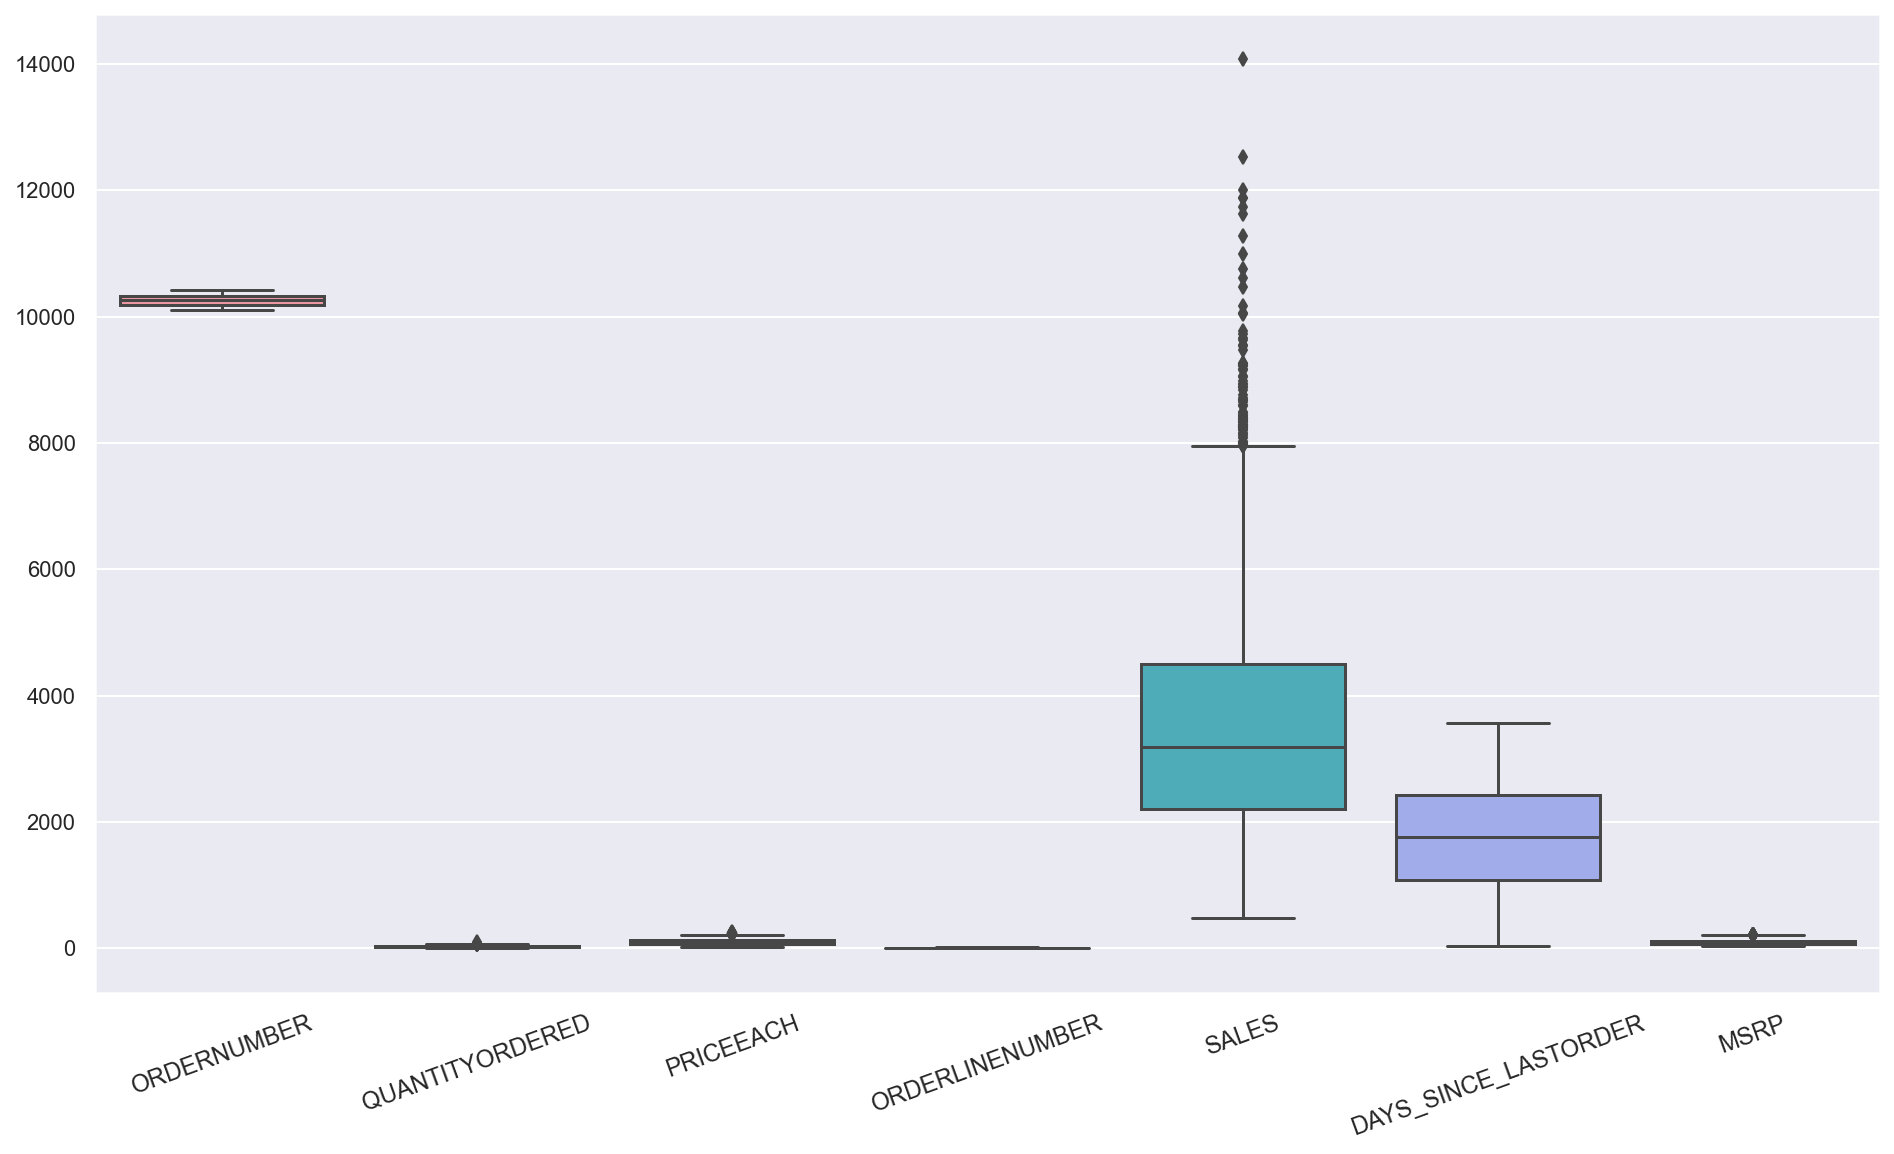

In [12]:
plt.figure(figsize=[16,9]);

a = sns.boxplot(data=df);
a.set_xticklabels(cont,rotation = 20, fontsize=12);
plt.savefig('df_outlier.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1em;color:#D68910"> Check Distribution of each variable

In [13]:
cont.remove('ORDERLINENUMBER')
cont.remove('ORDERNUMBER')

In [14]:
cont

['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'DAYS_SINCE_LASTORDER', 'MSRP']

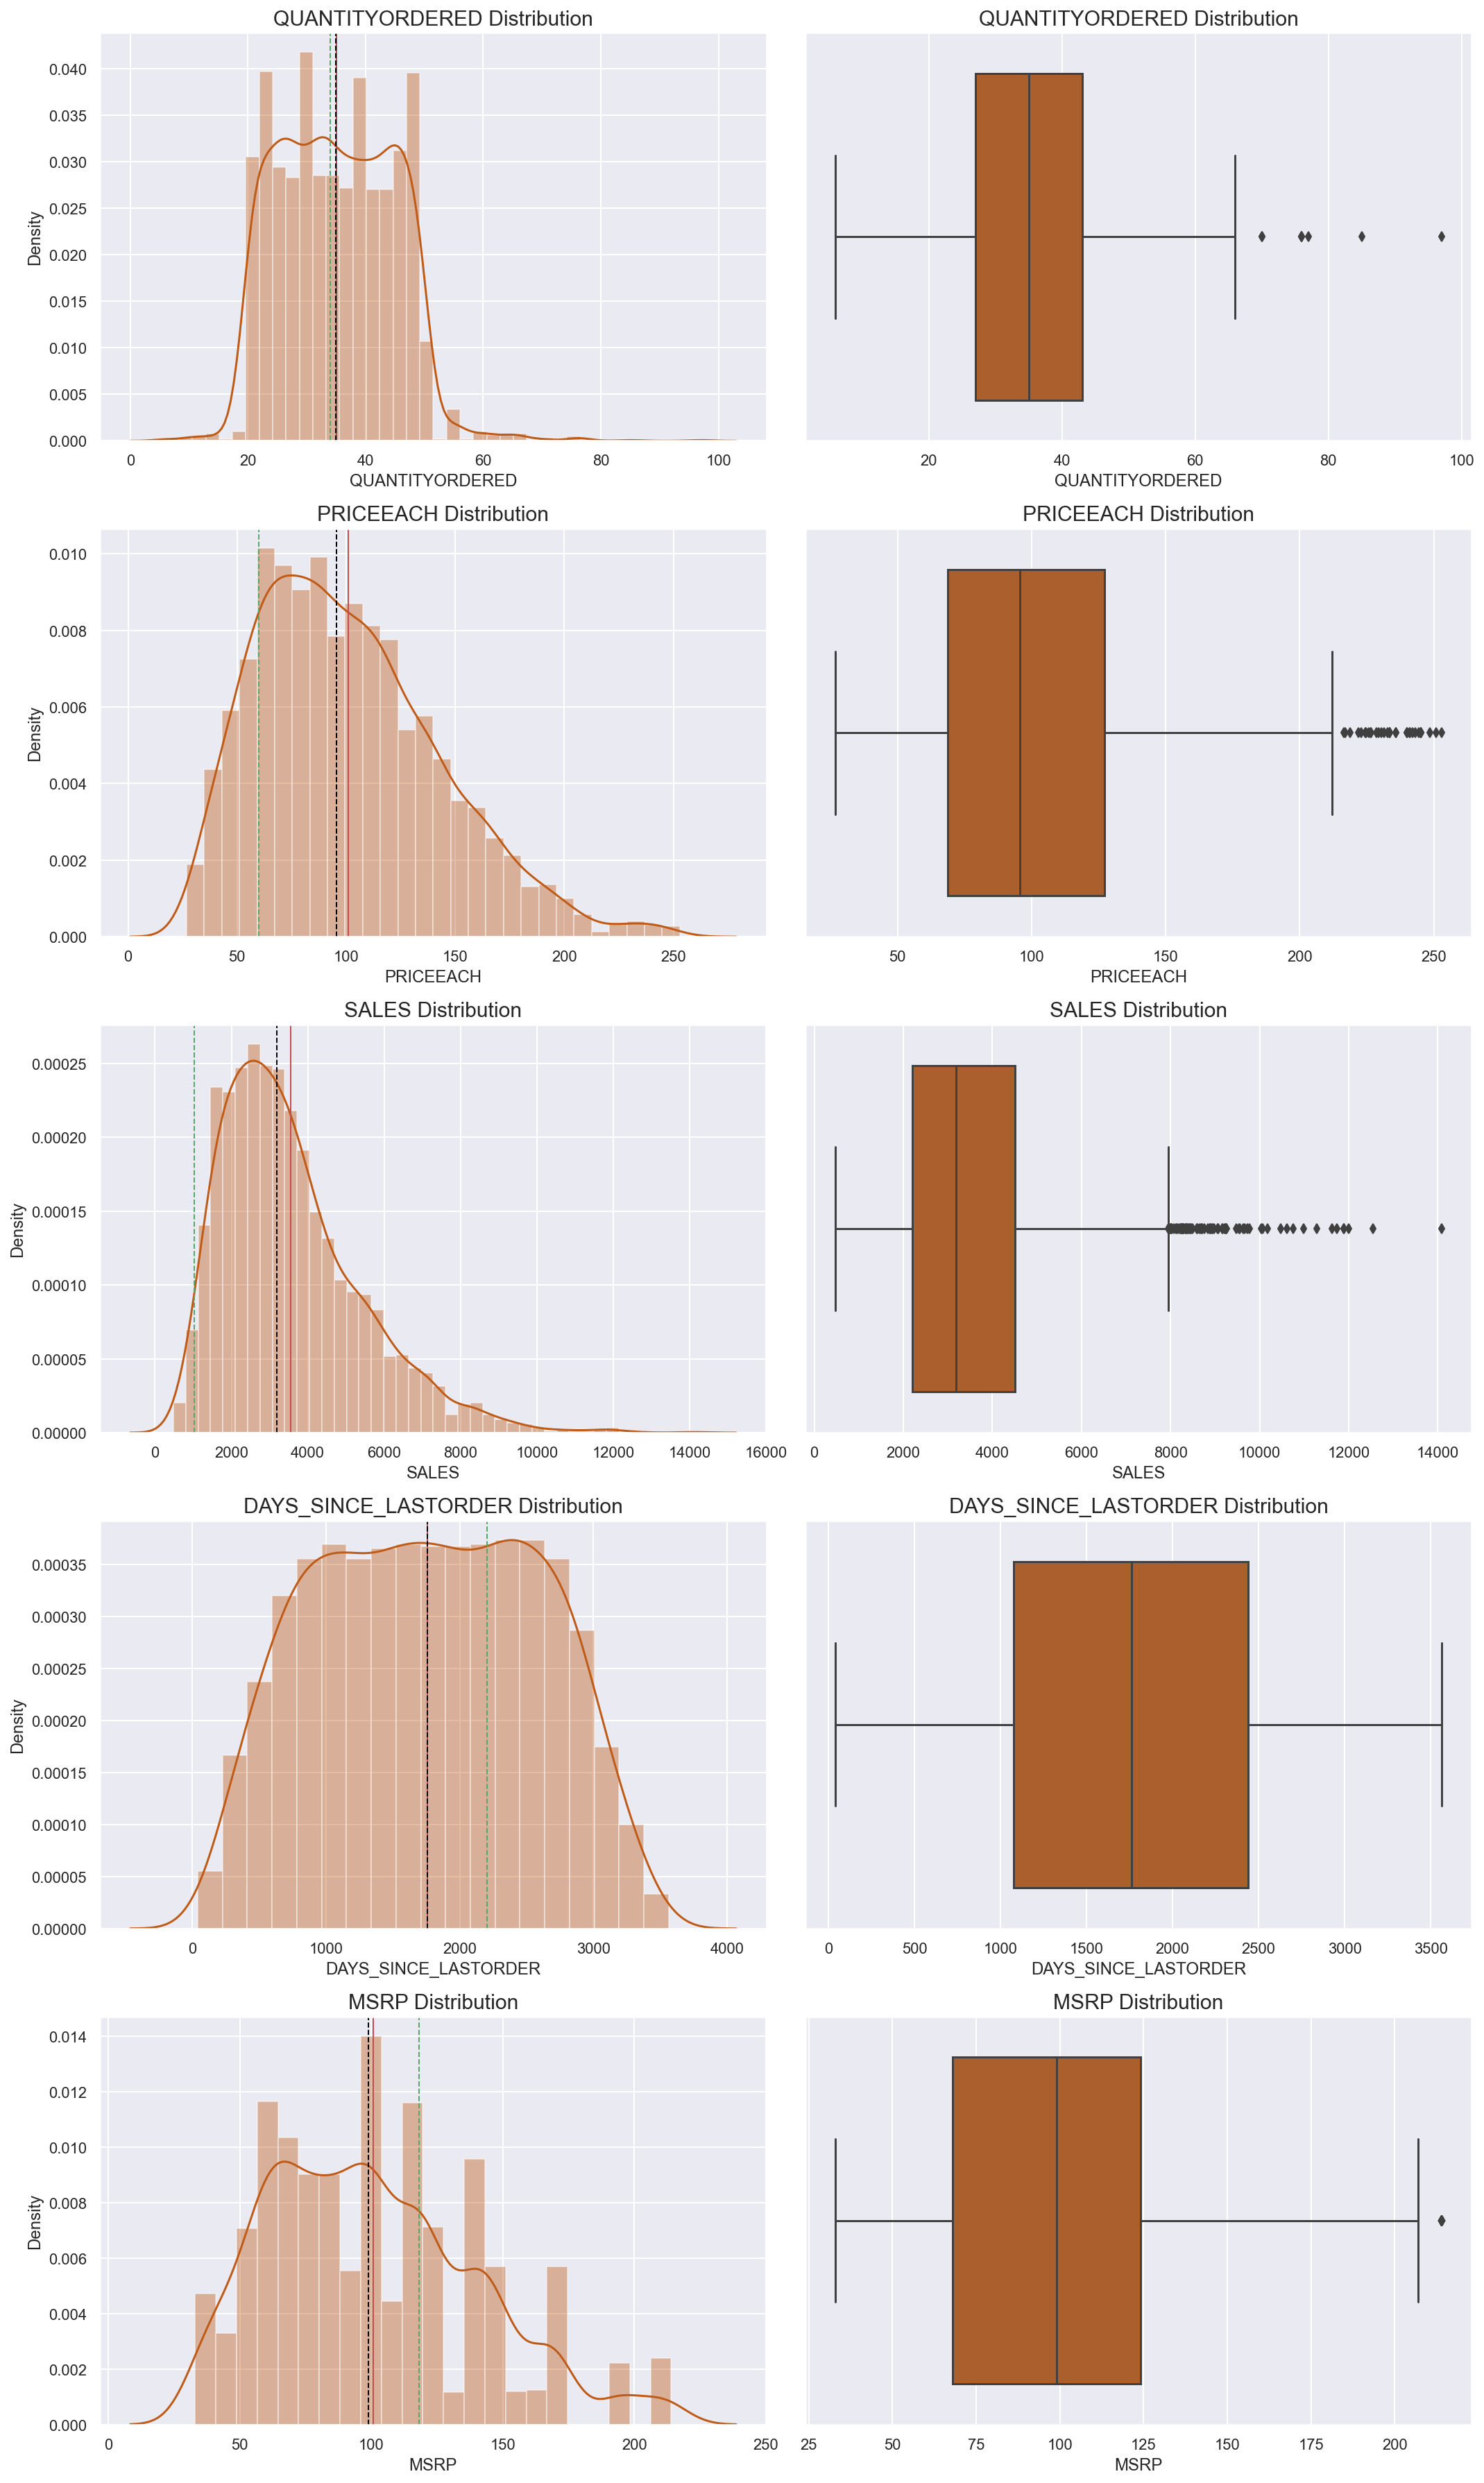

In [19]:
fig, axes = plt.subplots(nrows=5,ncols=2);

fig.set_size_inches(15, 25);

for i in range(0, len(cont)):
    a = sns.distplot(df[cont[i]], ax=axes[i][0]);
    a.set_title('{} Distribution'.format(cont[i]), fontsize=15);
    
    a.axvline(df[cont[i]].mean(), color='r', linewidth=1);
    a.axvline(df[cont[i]].median(), color='black', linestyle='dashed', linewidth=1);
    a.axvline(df[cont[i]].mode()[0], color='g', linestyle='dashed', linewidth=1);
    
    a = sns.boxplot(df[cont[i]], orient = "v" , ax=axes[i][1]);
    a.set_title('{} Distribution'.format(cont[i]), fontsize=15);
    plt.tight_layout();

plt.savefig('df_Distribution.jpg', bbox_inches='tight');

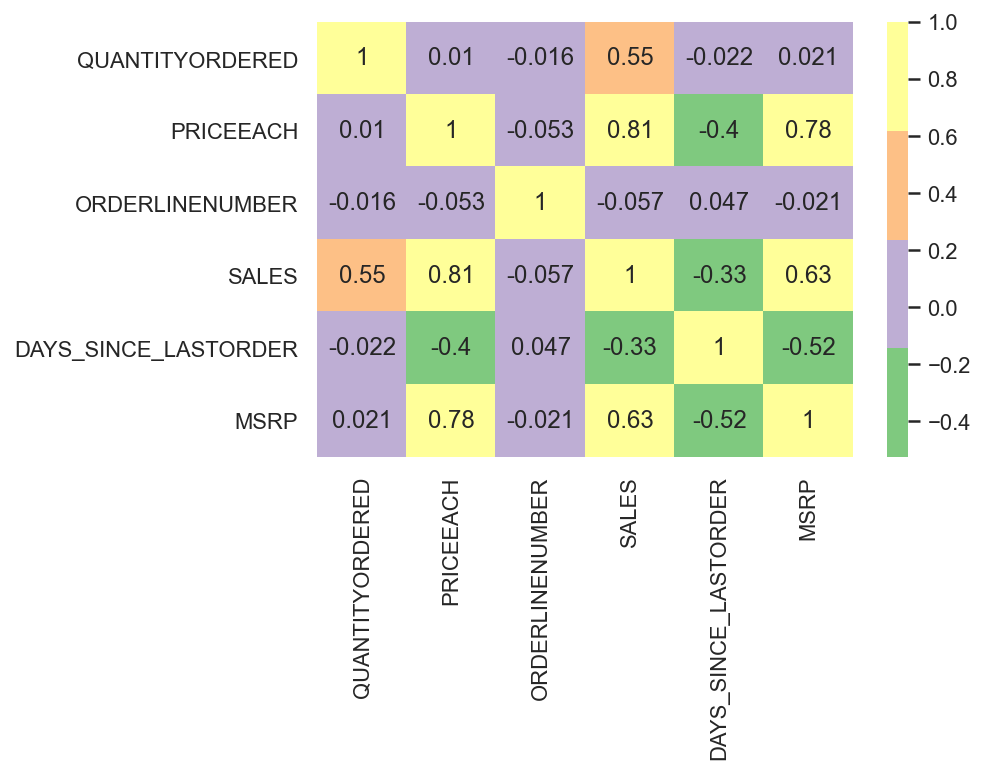

In [44]:
sns.heatmap(df.drop(['ORDERNUMBER'], axis=1).corr(), annot=True, fmt='.2g', cmap='Accent', center=1);
plt.savefig('df_corr_heatmap.jpg', bbox_inches='tight');

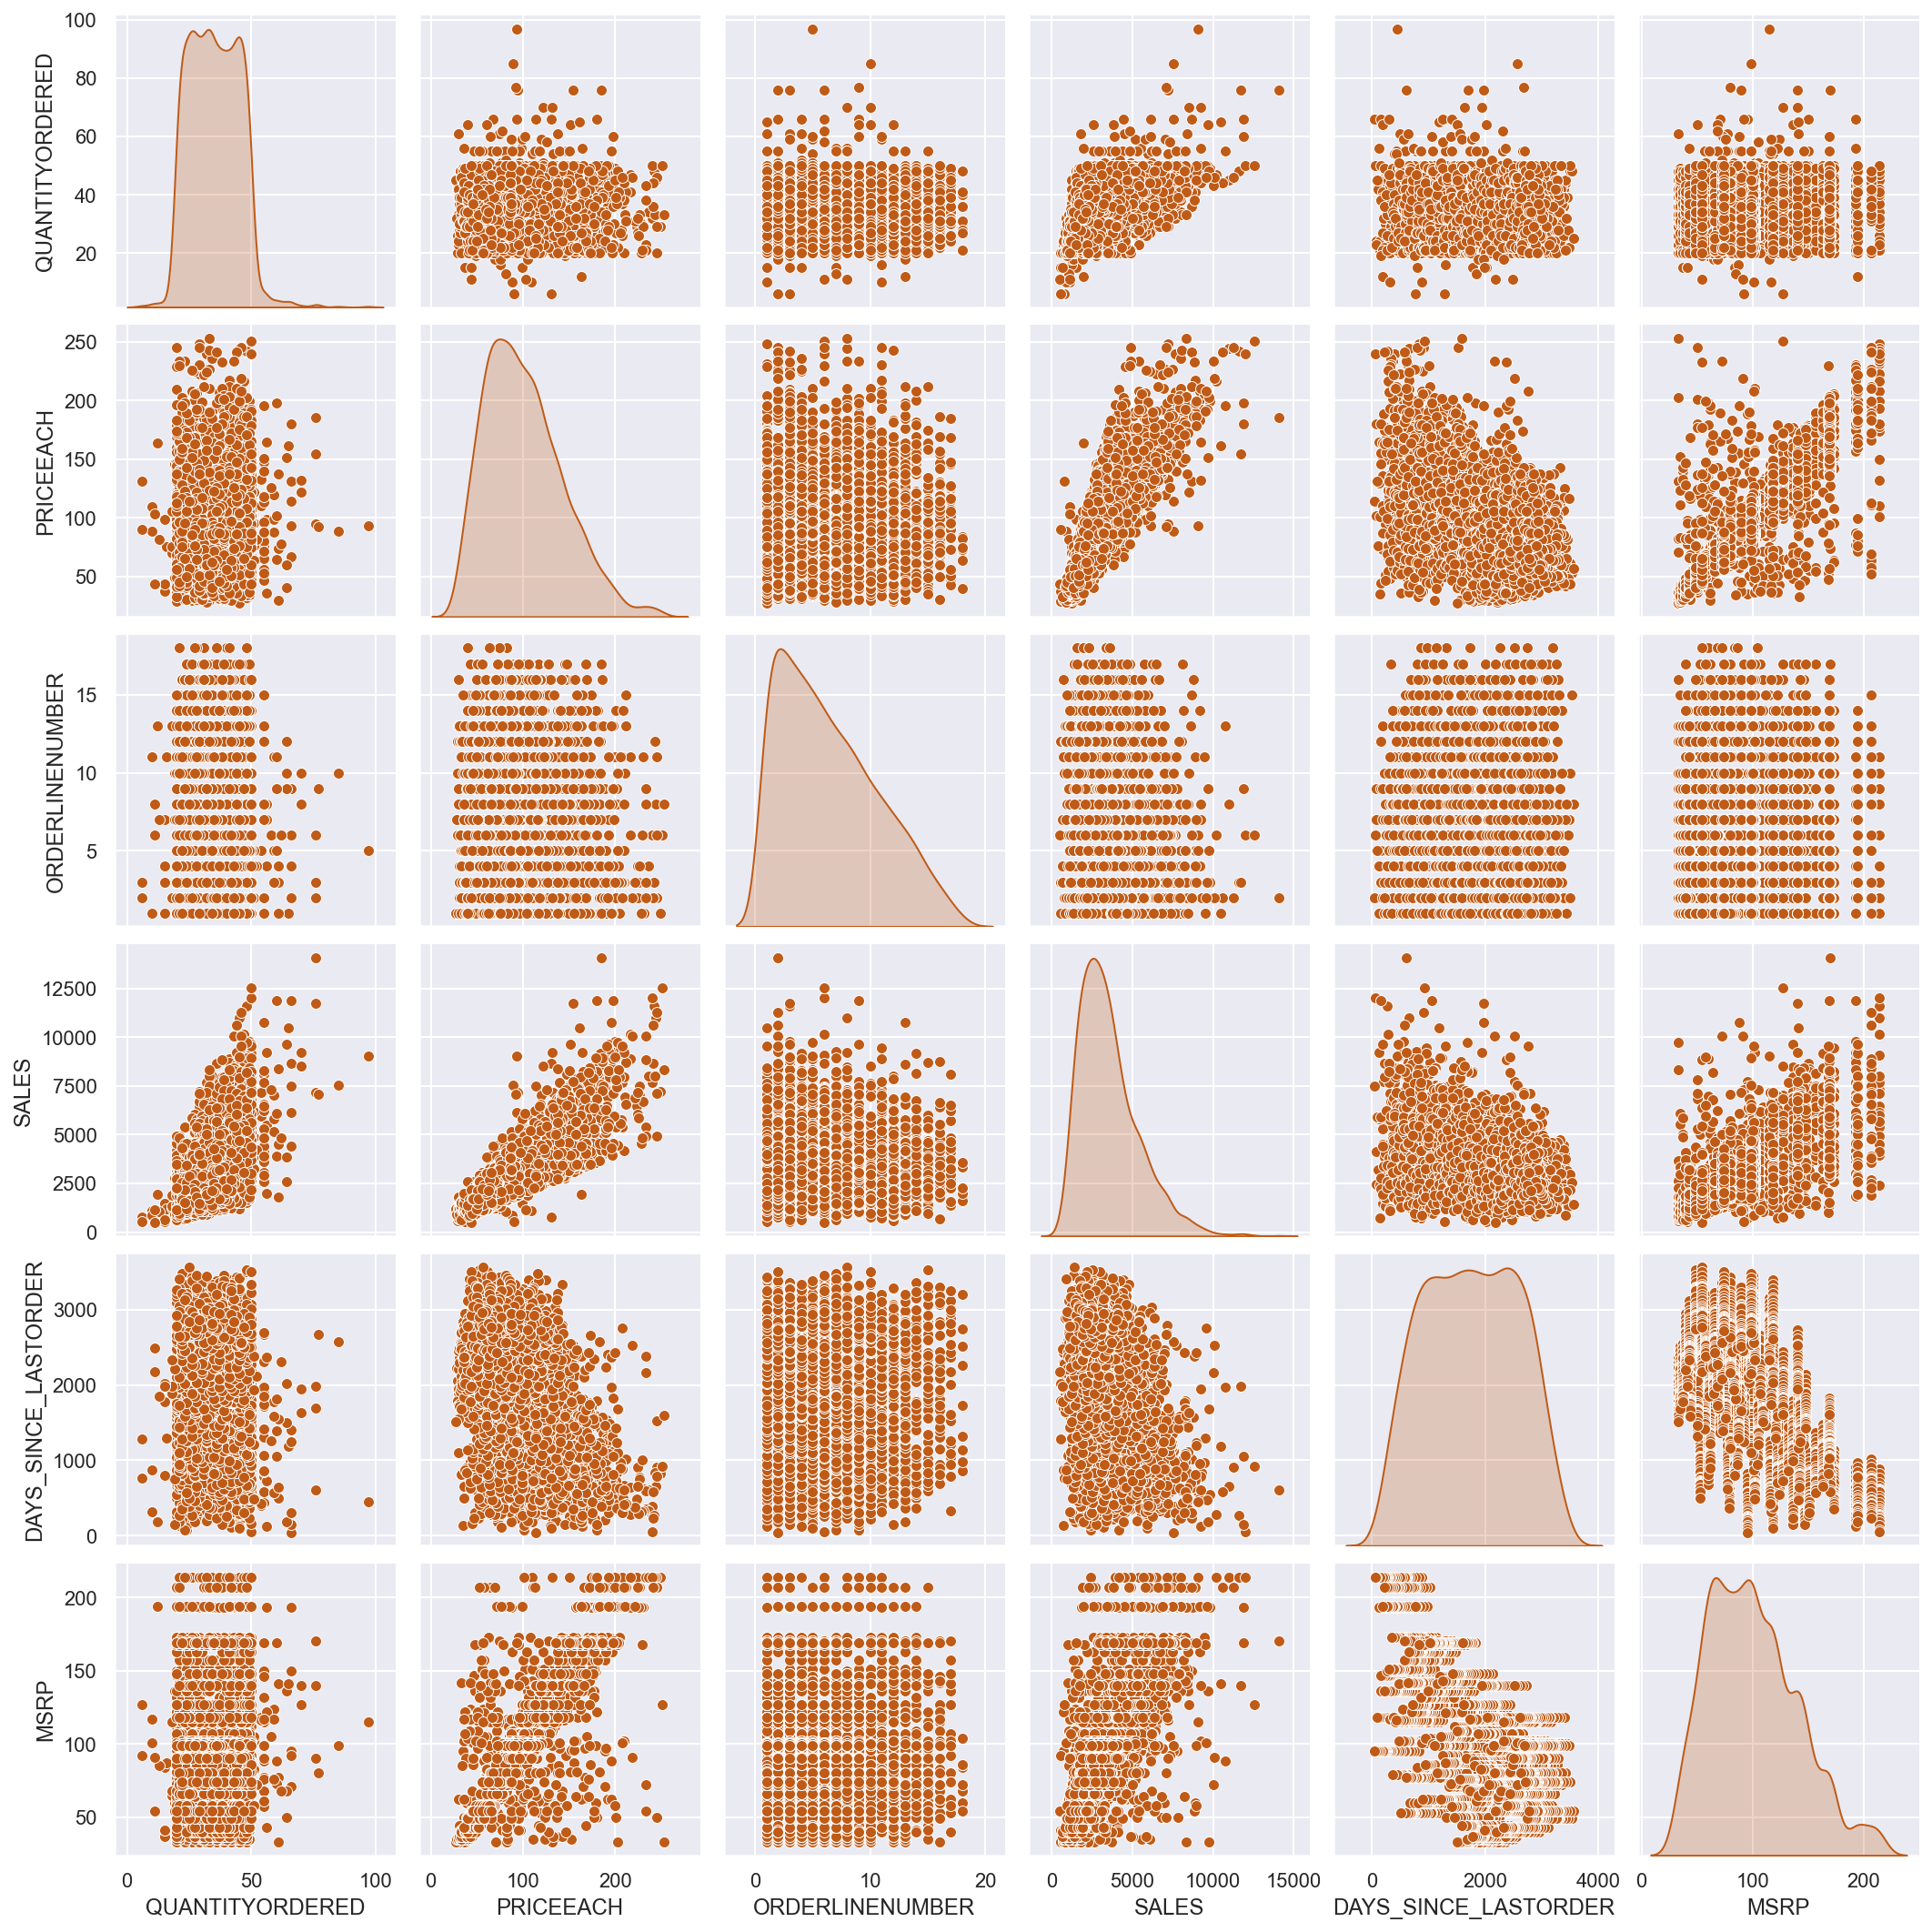

In [32]:
sns.pairplot(df.drop(['ORDERNUMBER'], axis=1), diag_kind='kde', palette='PiYG');
plt.savefig('df_pairplot.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#0e92ea"> Time Series Analysis

In [51]:

plt.rcParams['figure.figsize'] = 16, 9

In [52]:
df1 = df[['SALES', 'PRODUCTLINE','ORDERDATE']]
df1

SALES  PRODUCTLINE  ORDERDATE
0     2871.00  Motorcycles 2018-02-24
1     2765.90  Motorcycles 2018-05-07
2     3884.34  Motorcycles 2018-07-01
3     3746.70  Motorcycles 2018-08-25
4     3479.76  Motorcycles 2018-10-28
...       ...          ...        ...
2742  2244.40        Ships 2019-12-02
2743  3978.51        Ships 2020-01-31
2744  5417.57        Ships 2020-03-01
2745  2116.16        Ships 2020-03-28
2746  3079.44        Ships 2020-05-06

[2747 rows x 3 columns]

In [53]:
df2 = df1.copy()

In [54]:
df2['YEAR'] = pd.PeriodIndex(df2['ORDERDATE'], freq='Y')
df2['MONTH'] = pd.PeriodIndex(df2['ORDERDATE'], freq='M')
df2['QUARTER'] = pd.PeriodIndex(df2['ORDERDATE'], freq='Q')
df2['WEEK'] = pd.PeriodIndex(df2['ORDERDATE'], freq='W')

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SALES        2747 non-null   float64       
 1   PRODUCTLINE  2747 non-null   object        
 2   ORDERDATE    2747 non-null   datetime64[ns]
 3   YEAR         2747 non-null   period[A-DEC] 
 4   MONTH        2747 non-null   period[M]     
 5   QUARTER      2747 non-null   period[Q-DEC] 
 6   WEEK         2747 non-null   period[W-SUN] 
dtypes: datetime64[ns](1), float64(1), object(1), period[A-DEC](1), period[M](1), period[Q-DEC](1), period[W-SUN](1)
memory usage: 150.4+ KB


In [56]:
df2

SALES  PRODUCTLINE  ORDERDATE  YEAR    MONTH QUARTER  \
0     2871.00  Motorcycles 2018-02-24  2018  2018-02  2018Q1   
1     2765.90  Motorcycles 2018-05-07  2018  2018-05  2018Q2   
2     3884.34  Motorcycles 2018-07-01  2018  2018-07  2018Q3   
3     3746.70  Motorcycles 2018-08-25  2018  2018-08  2018Q3   
4     3479.76  Motorcycles 2018-10-28  2018  2018-10  2018Q4   
...       ...          ...        ...   ...      ...     ...   
2742  2244.40        Ships 2019-12-02  2019  2019-12  2019Q4   
2743  3978.51        Ships 2020-01-31  2020  2020-01  2020Q1   
2744  5417.57        Ships 2020-03-01  2020  2020-03  2020Q1   
2745  2116.16        Ships 2020-03-28  2020  2020-03  2020Q1   
2746  3079.44        Ships 2020-05-06  2020  2020-05  2020Q2   

                       WEEK  
0     2018-02-19/2018-02-25  
1     2018-05-07/2018-05-13  
2     2018-06-25/2018-07-01  
3     2018-08-20/2018-08-26  
4     2018-10-22/2018-10-28  
...                     ...  
2742  2019-12-02/2019-12-08  
2743  2020-01-27/2020-02-02  
2744  2020-02-24/2020-03-01  
2745  2020-03-23/2020-03-29  
2746  2020-05-04/2020-05-10  

[2747 rows x 7 columns]

In [57]:
print('First date of Sales data = ', min(df2['ORDERDATE']))
print('Last date of Sales data = ', max(df2['ORDERDATE']))

First date of Sales data =  2018-01-06 00:00:00
Last date of Sales data =  2020-05-31 00:00:00


### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - WHOLE DATA

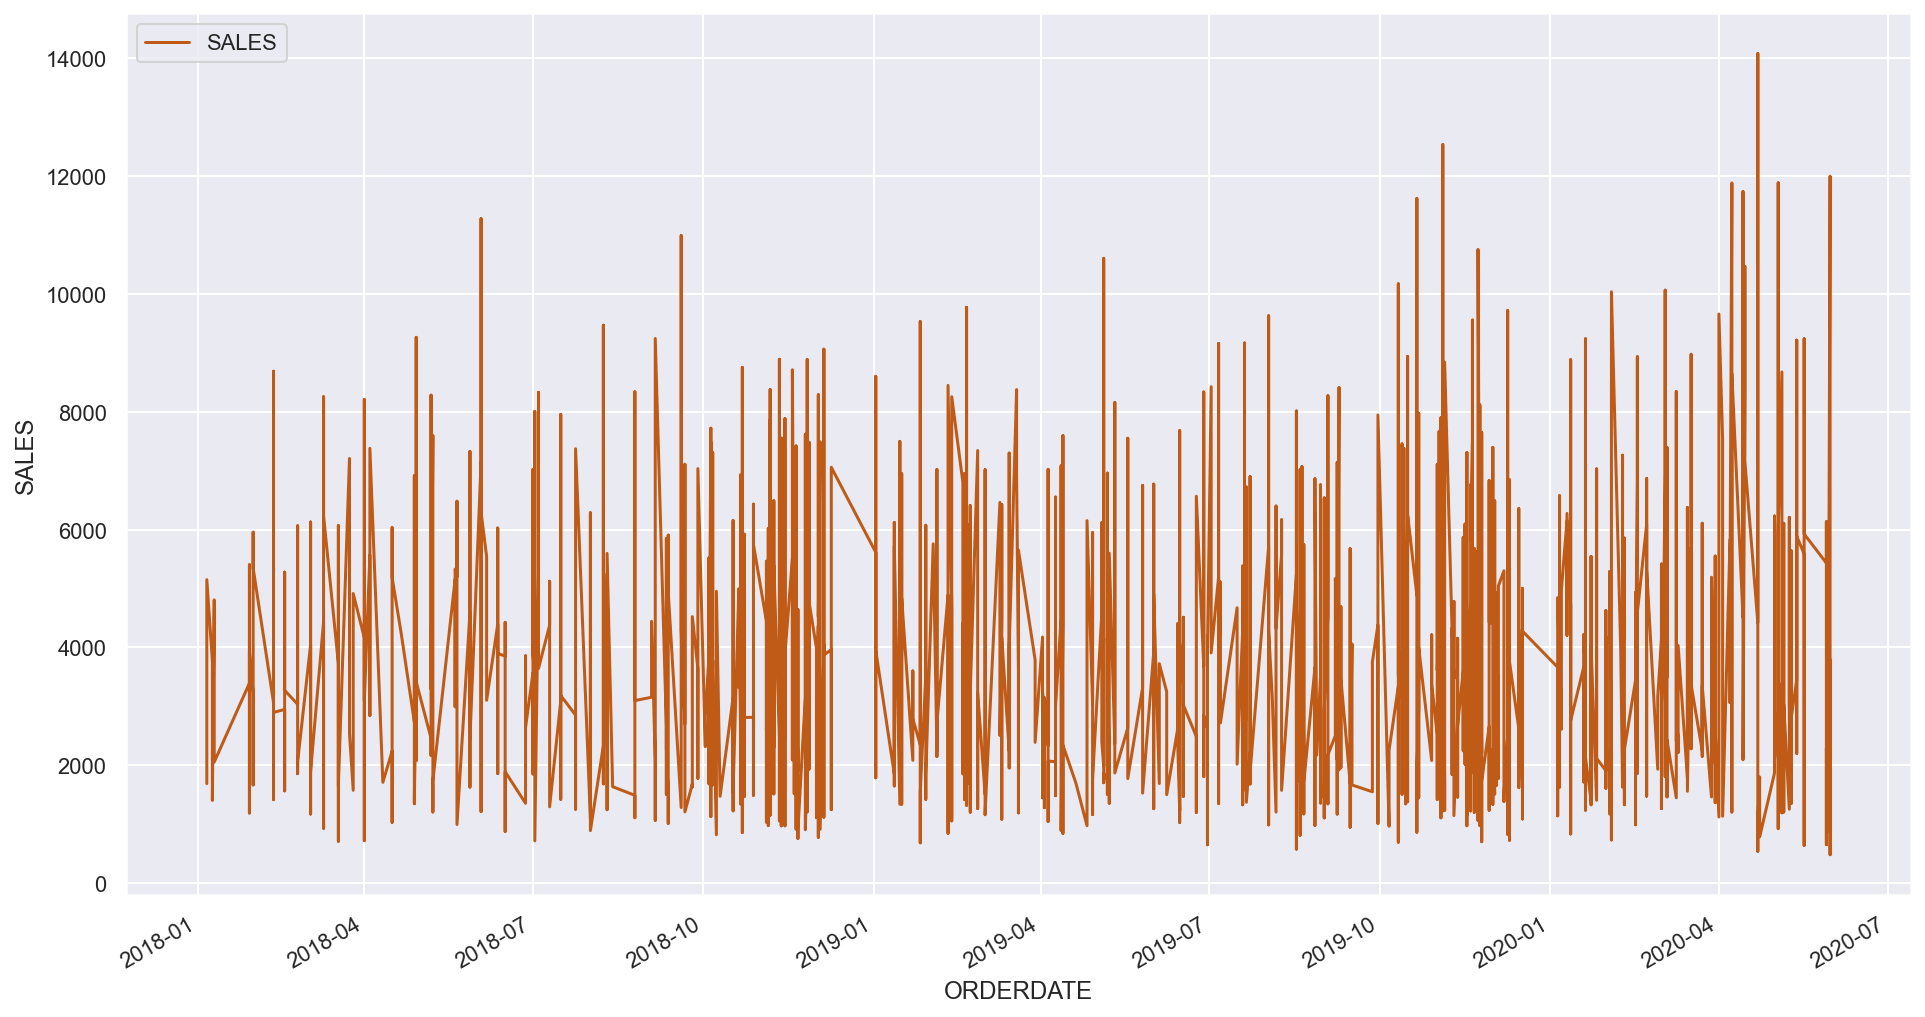

In [78]:
df2.plot('ORDERDATE', 'SALES');
plt.ylabel('SALES');
plt.savefig('ts_wholedata.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - YEARLY

In [58]:
df3 = df2.copy()
df_yr = pd.DataFrame(df3[['YEAR', 'SALES']].groupby('YEAR').sum())
df_yr

SALES
YEAR            
2018  3353014.06
2019  4669924.56
2020  1737283.09

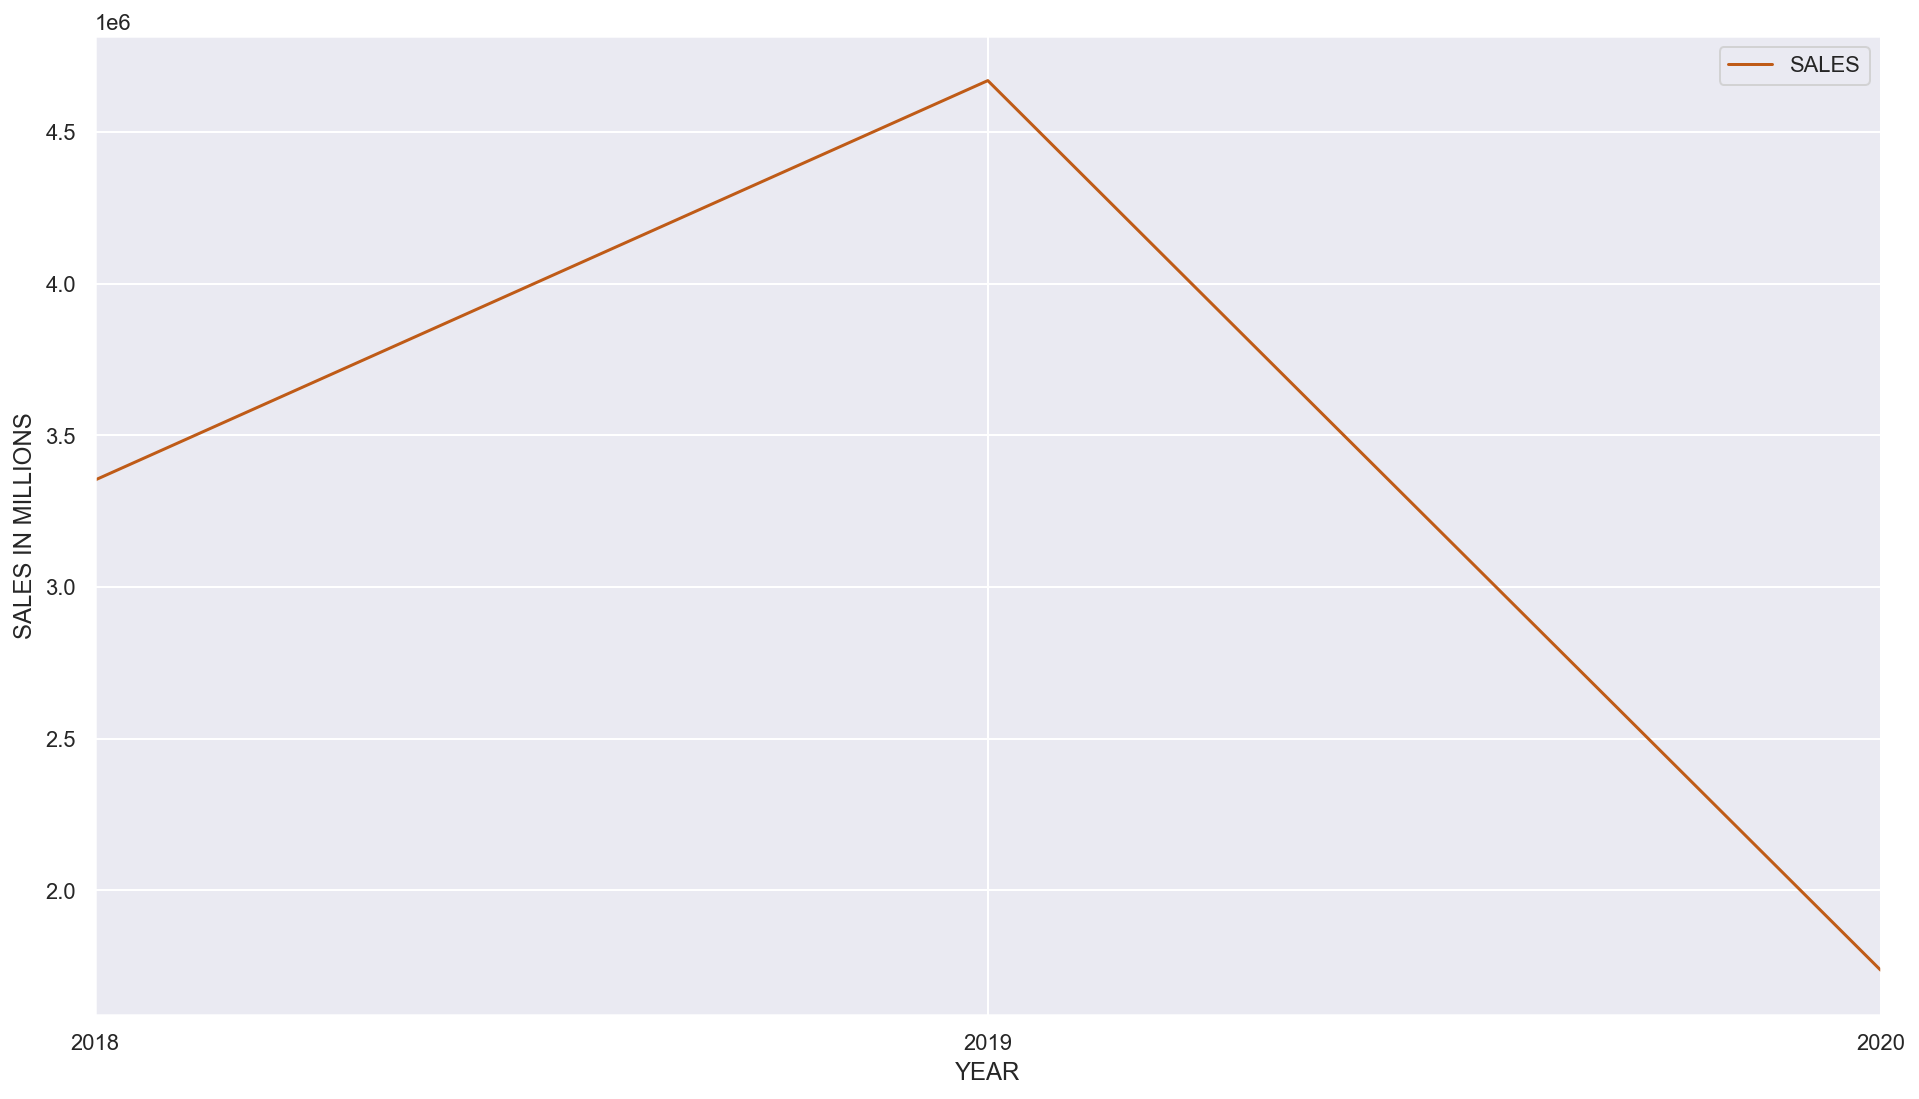

In [79]:
df_yr.plot();
plt.ylabel('SALES IN MILLIONS');
plt.savefig('ts_YEAR.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - QUARTERLY

In [60]:
df3 = df2.copy()
df_qtr = pd.DataFrame(df3[['QUARTER', 'SALES']].groupby('QUARTER').sum())
df_qtr

SALES
QUARTER            
2018Q1    426399.11
2018Q2    562365.22
2018Q3    649514.54
2018Q4   1714735.19
2019Q1    809841.36
2019Q2    766260.73
2019Q3   1109396.27
2019Q4   1984426.20
2020Q1   1017788.74
2020Q2    719494.35

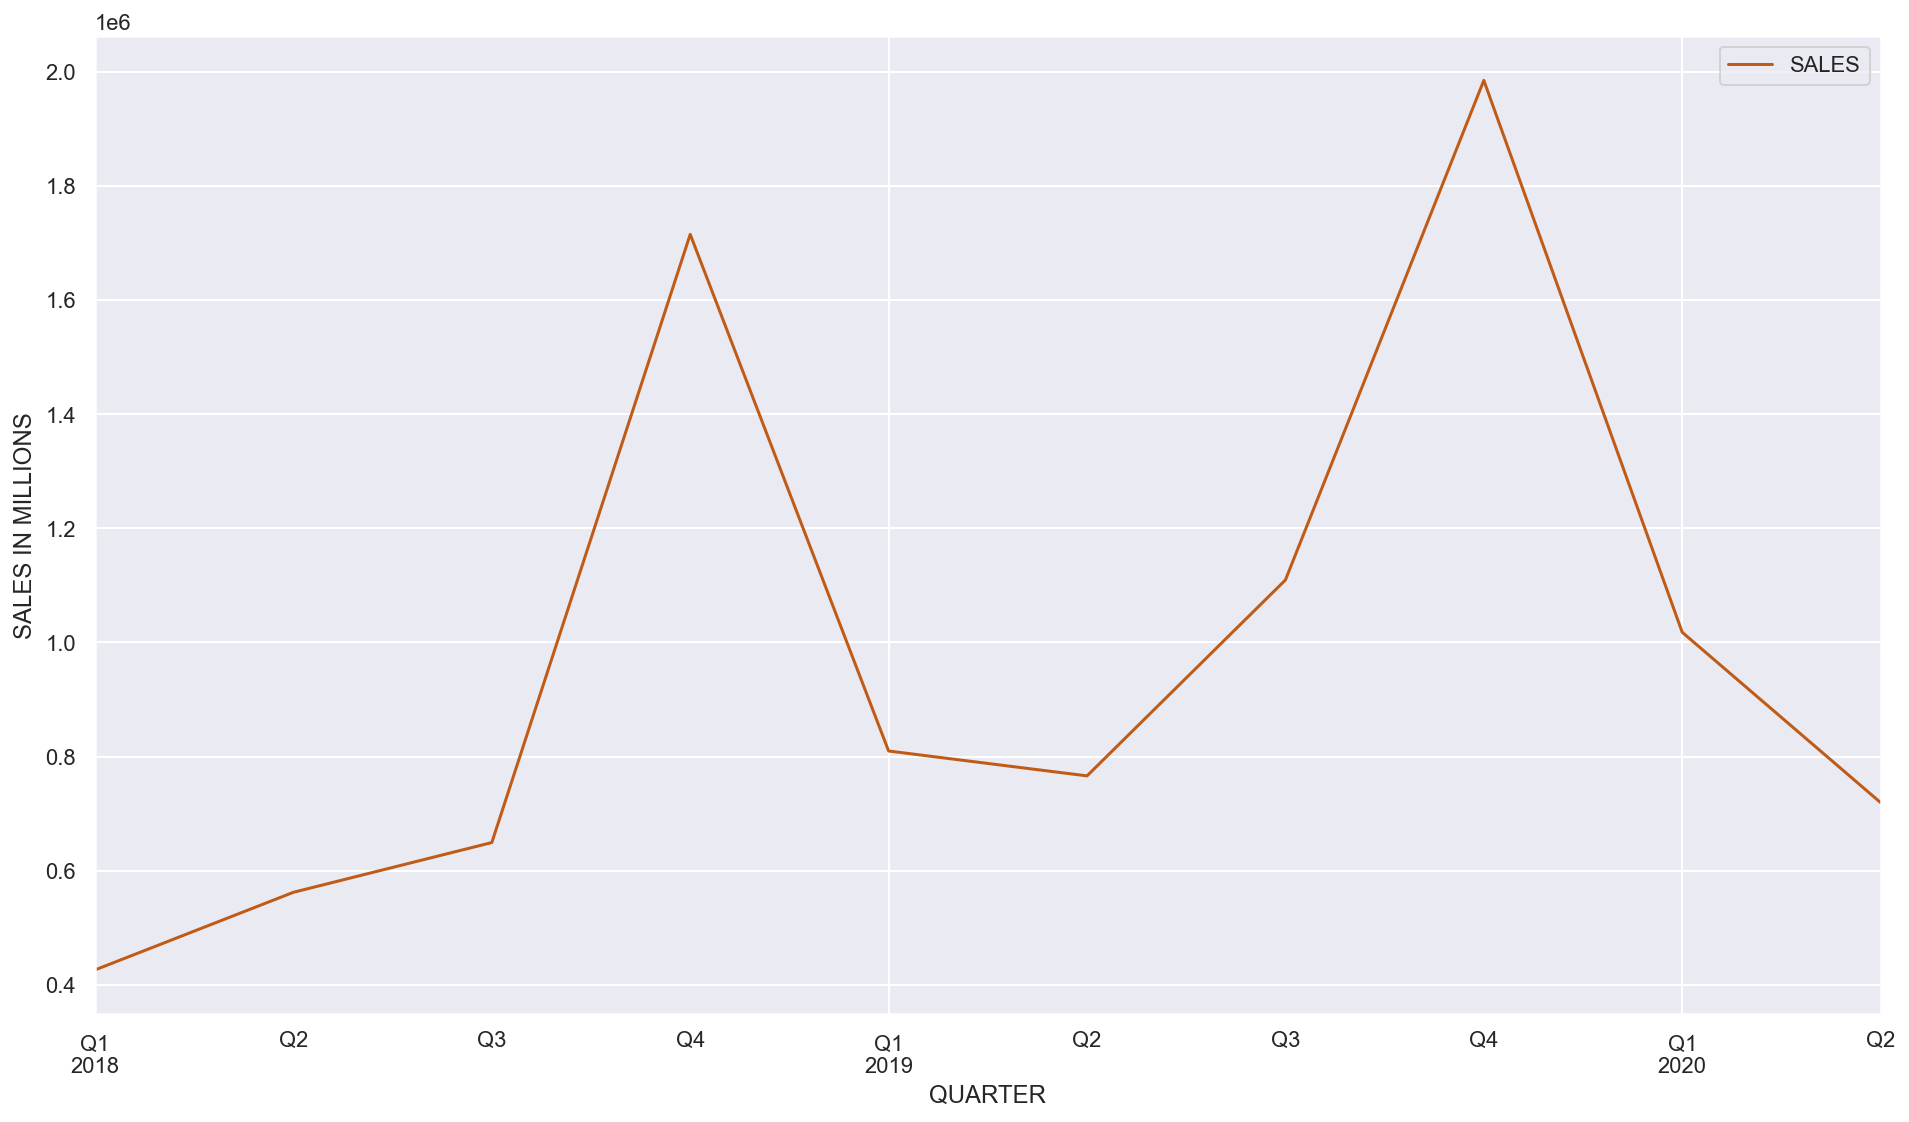

In [98]:
df_qtr.plot();
plt.ylabel('SALES IN MILLIONS');
plt.savefig('ts_QUARTER.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - MONTHLY

In [62]:
df3 = df2.copy()
df_month = pd.DataFrame(df3[['MONTH', 'SALES']].groupby('MONTH').sum())
df_month

SALES
MONTH              
2018-01   129753.60
2018-02   140836.19
2018-03   155809.32
2018-04   201609.55
2018-05   192673.11
2018-06   168082.56
2018-07   187731.88
2018-08   197809.30
2018-09   263973.36
2018-10   448452.95
2018-11  1029837.66
2018-12   236444.58
2019-01   292688.10
2019-02   311419.53
2019-03   205733.73
2019-04   206148.12
2019-05   273438.39
2019-06   286674.22
2019-07   327144.09
2019-08   461501.27
2019-09   320750.91
2019-10   552924.25
2019-11  1058699.29
2019-12   372802.66
2020-01   339543.42
2020-02   303982.56
2020-03   374262.76
2020-04   261633.29
2020-05   457861.06

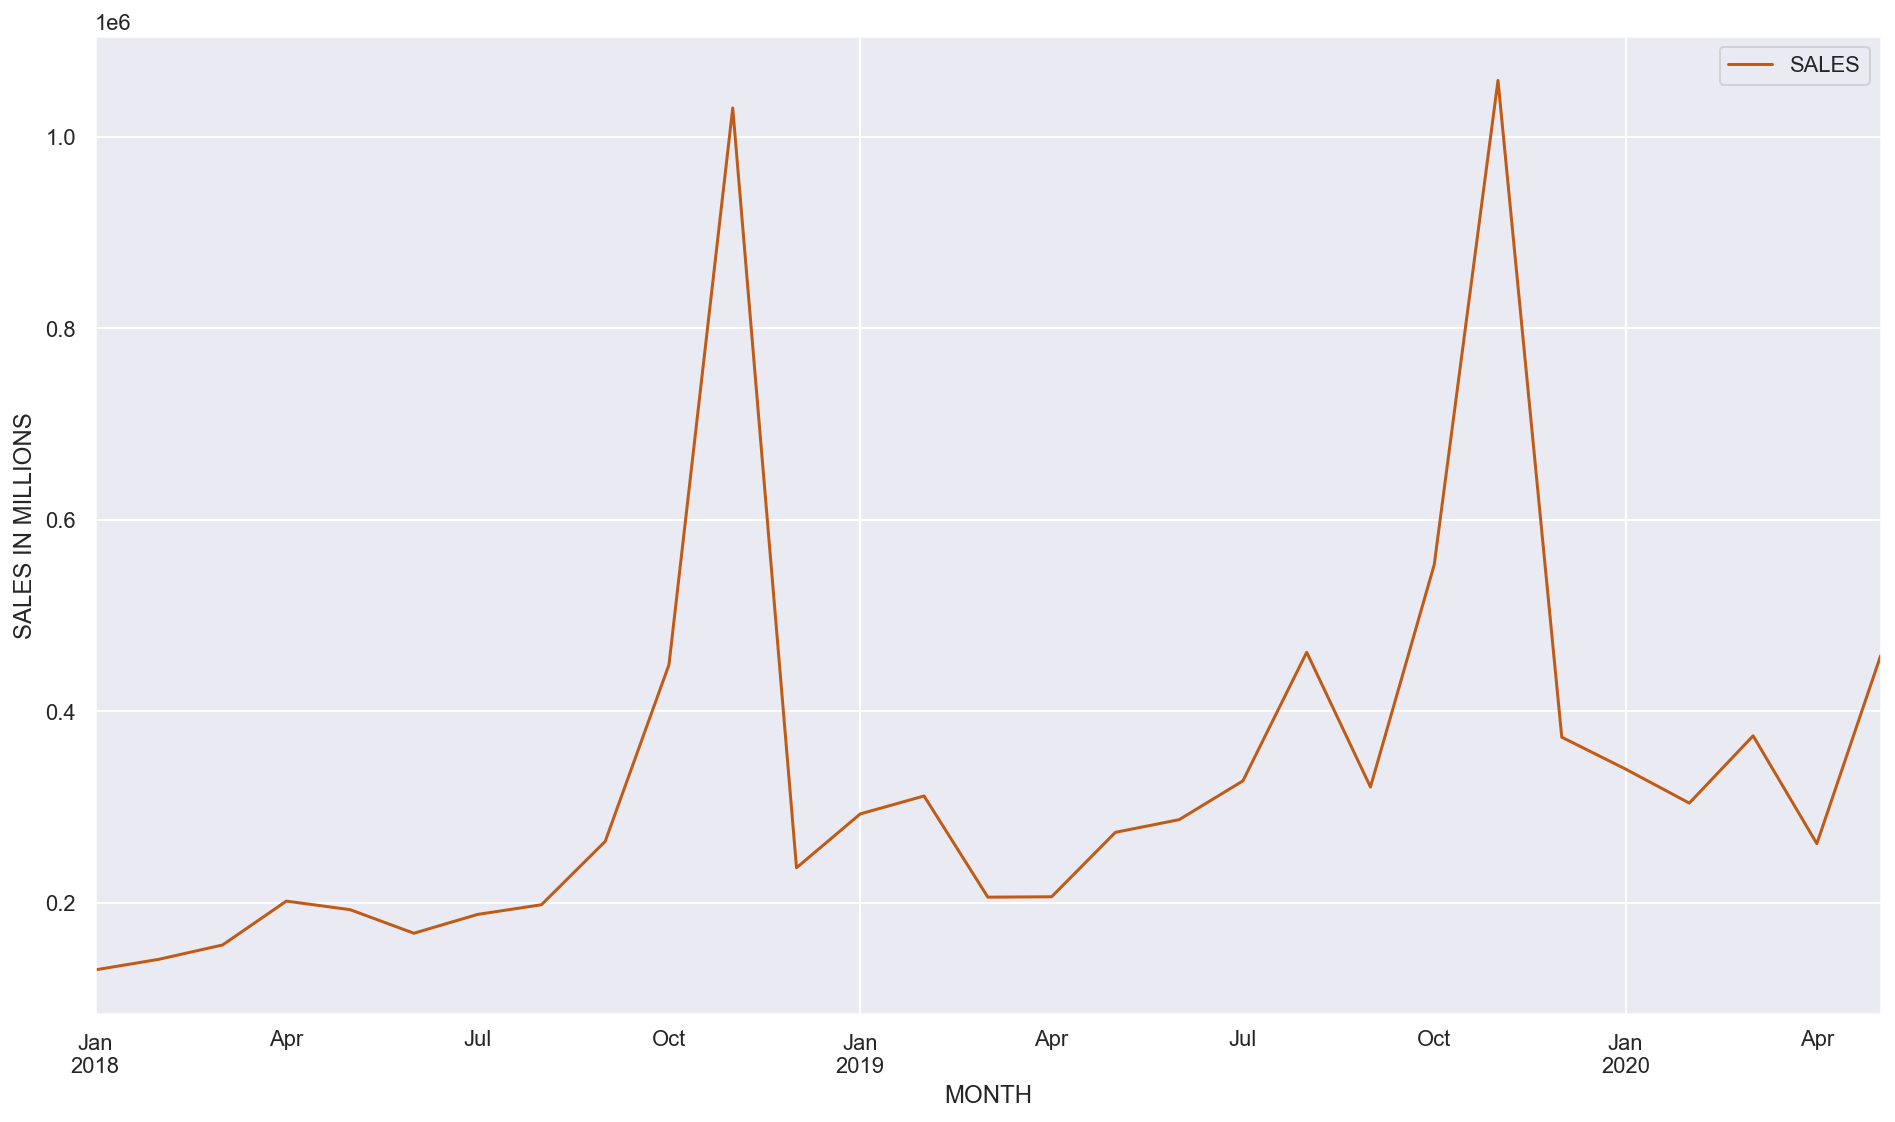

In [81]:
df_month.plot();
plt.ylabel('SALES IN MILLIONS');
plt.savefig('ts_MONTH.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - WEEKLY

In [64]:
df3 = df2.copy()
df_wkly = pd.DataFrame(df3[['WEEK', 'SALES']].groupby('WEEK').sum())
df_wkly

SALES
WEEK                            
2018-01-01/2018-01-07   12133.25
2018-01-08/2018-01-14   18296.39
2018-01-29/2018-02-04   99323.96
2018-02-05/2018-02-11   58871.11
2018-02-12/2018-02-18   56181.32
...                          ...
2020-04-20/2020-04-26   61024.62
2020-04-27/2020-05-03   85980.71
2020-05-04/2020-05-10  135853.39
2020-05-11/2020-05-17   91297.00
2020-05-25/2020-05-31  144729.96

[115 rows x 1 columns]

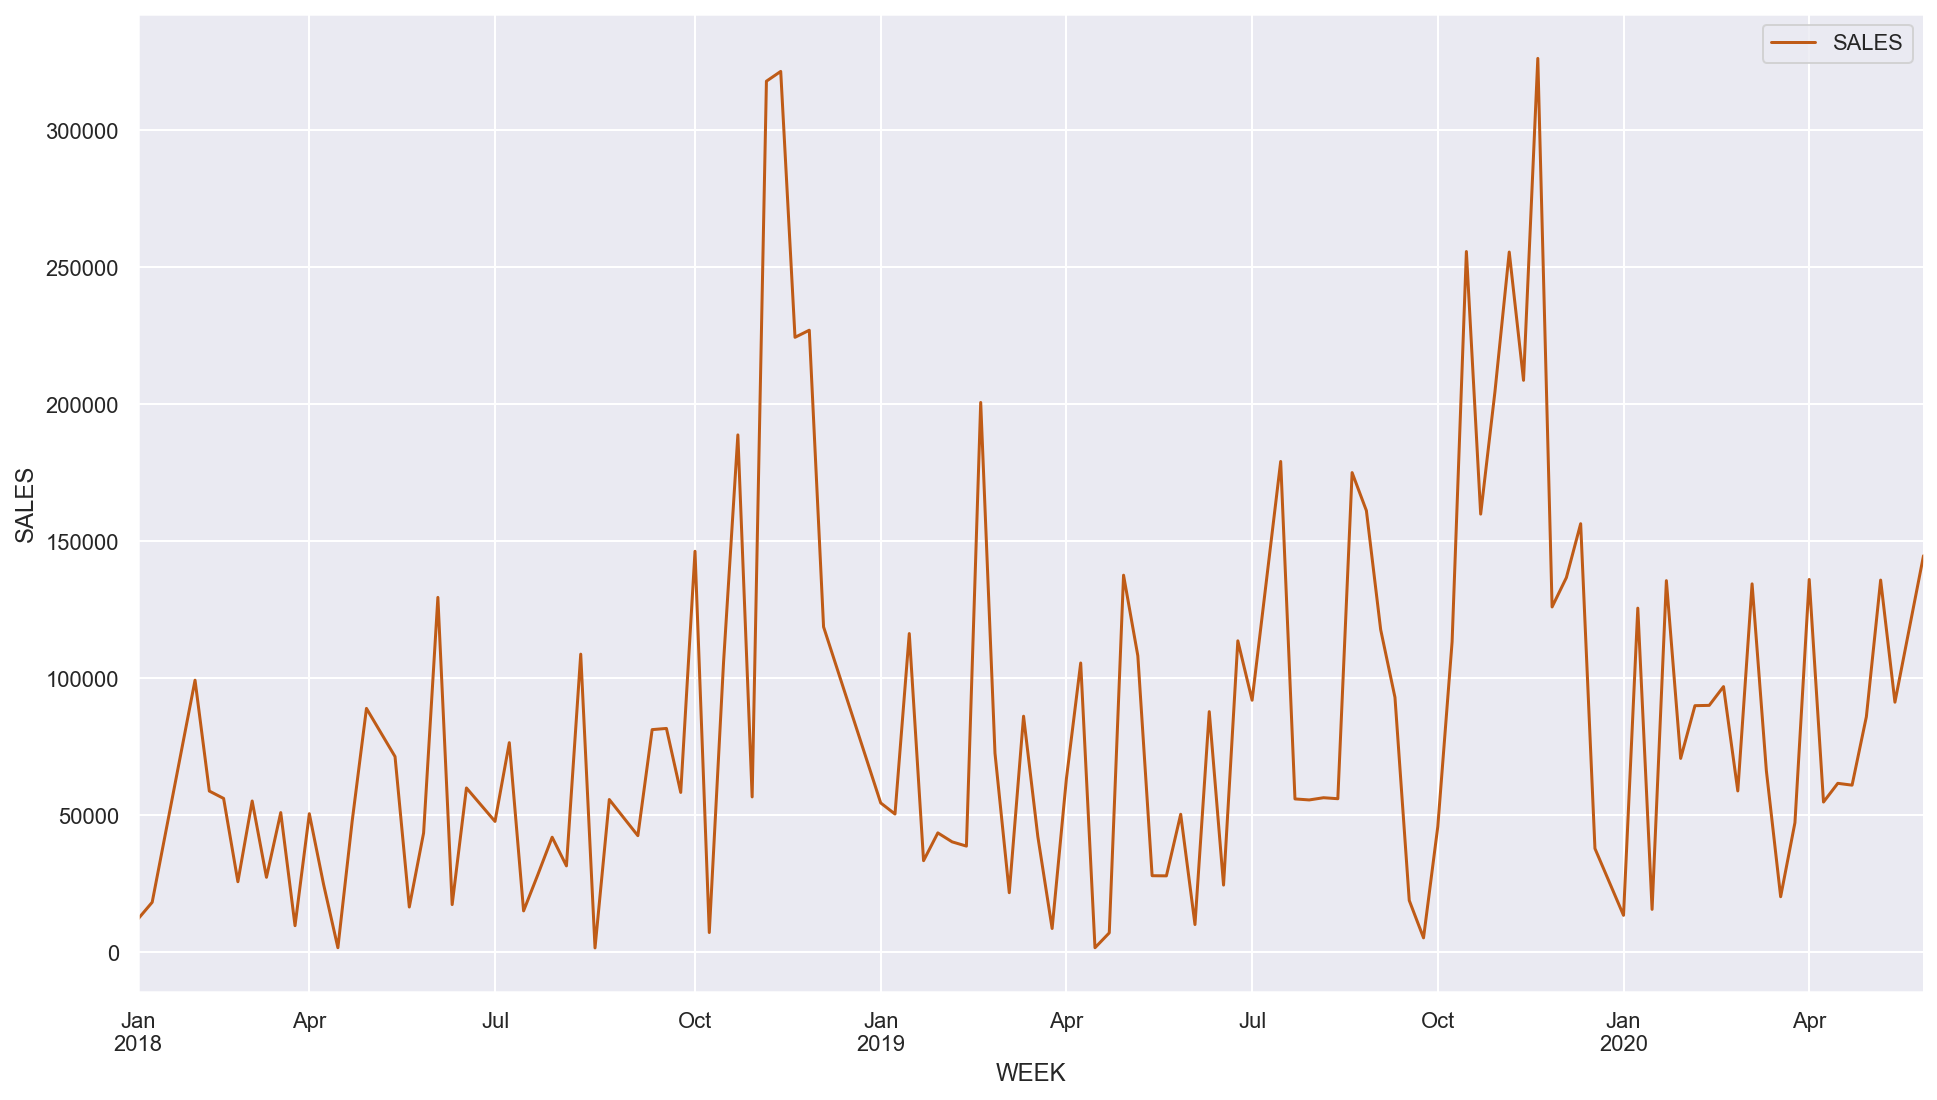

In [82]:
df_wkly.plot();
plt.ylabel('SALES');
plt.savefig('ts_WEEK.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - PRODUCT CATEGORY WISE

In [66]:
df.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'DAYS_SINCE_LASTORDER', 'STATUS', 'PRODUCTLINE',
       'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'CITY',
       'POSTALCODE', 'COUNTRY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [123]:
df3 = df.copy()
df_prod = pd.DataFrame(df3[['PRODUCTLINE', 'SALES']].groupby('PRODUCTLINE').sum())
df_prod.sort_values(by='SALES', ascending=False, inplace=True)
c = df_prod['SALES'][0]
v = df_prod['SALES'][1]
r = df_prod['SALES'][2]
t = sum(df_prod['SALES'])
c*100/t
v*100/t
r*100/t

39.37275867476168

18.51060082117745

11.388667419933025

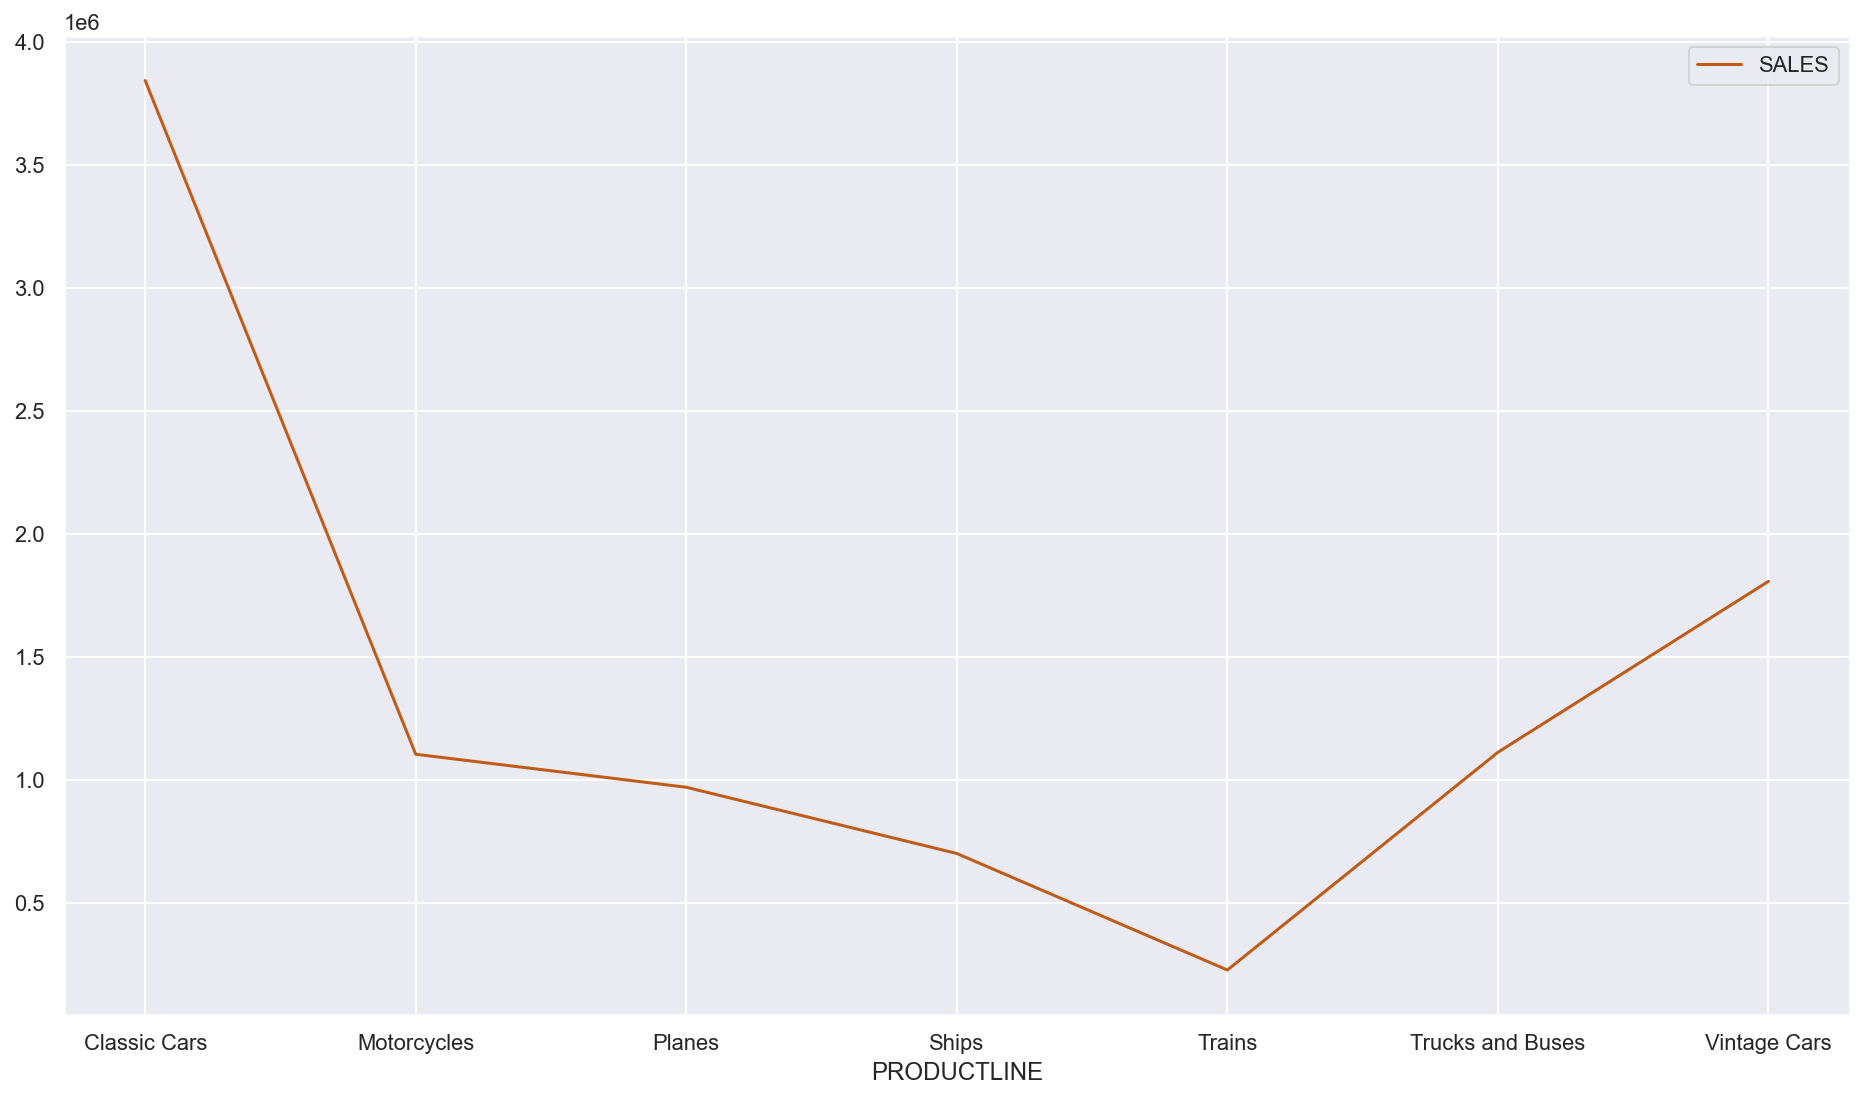

In [68]:
df_prod.plot();

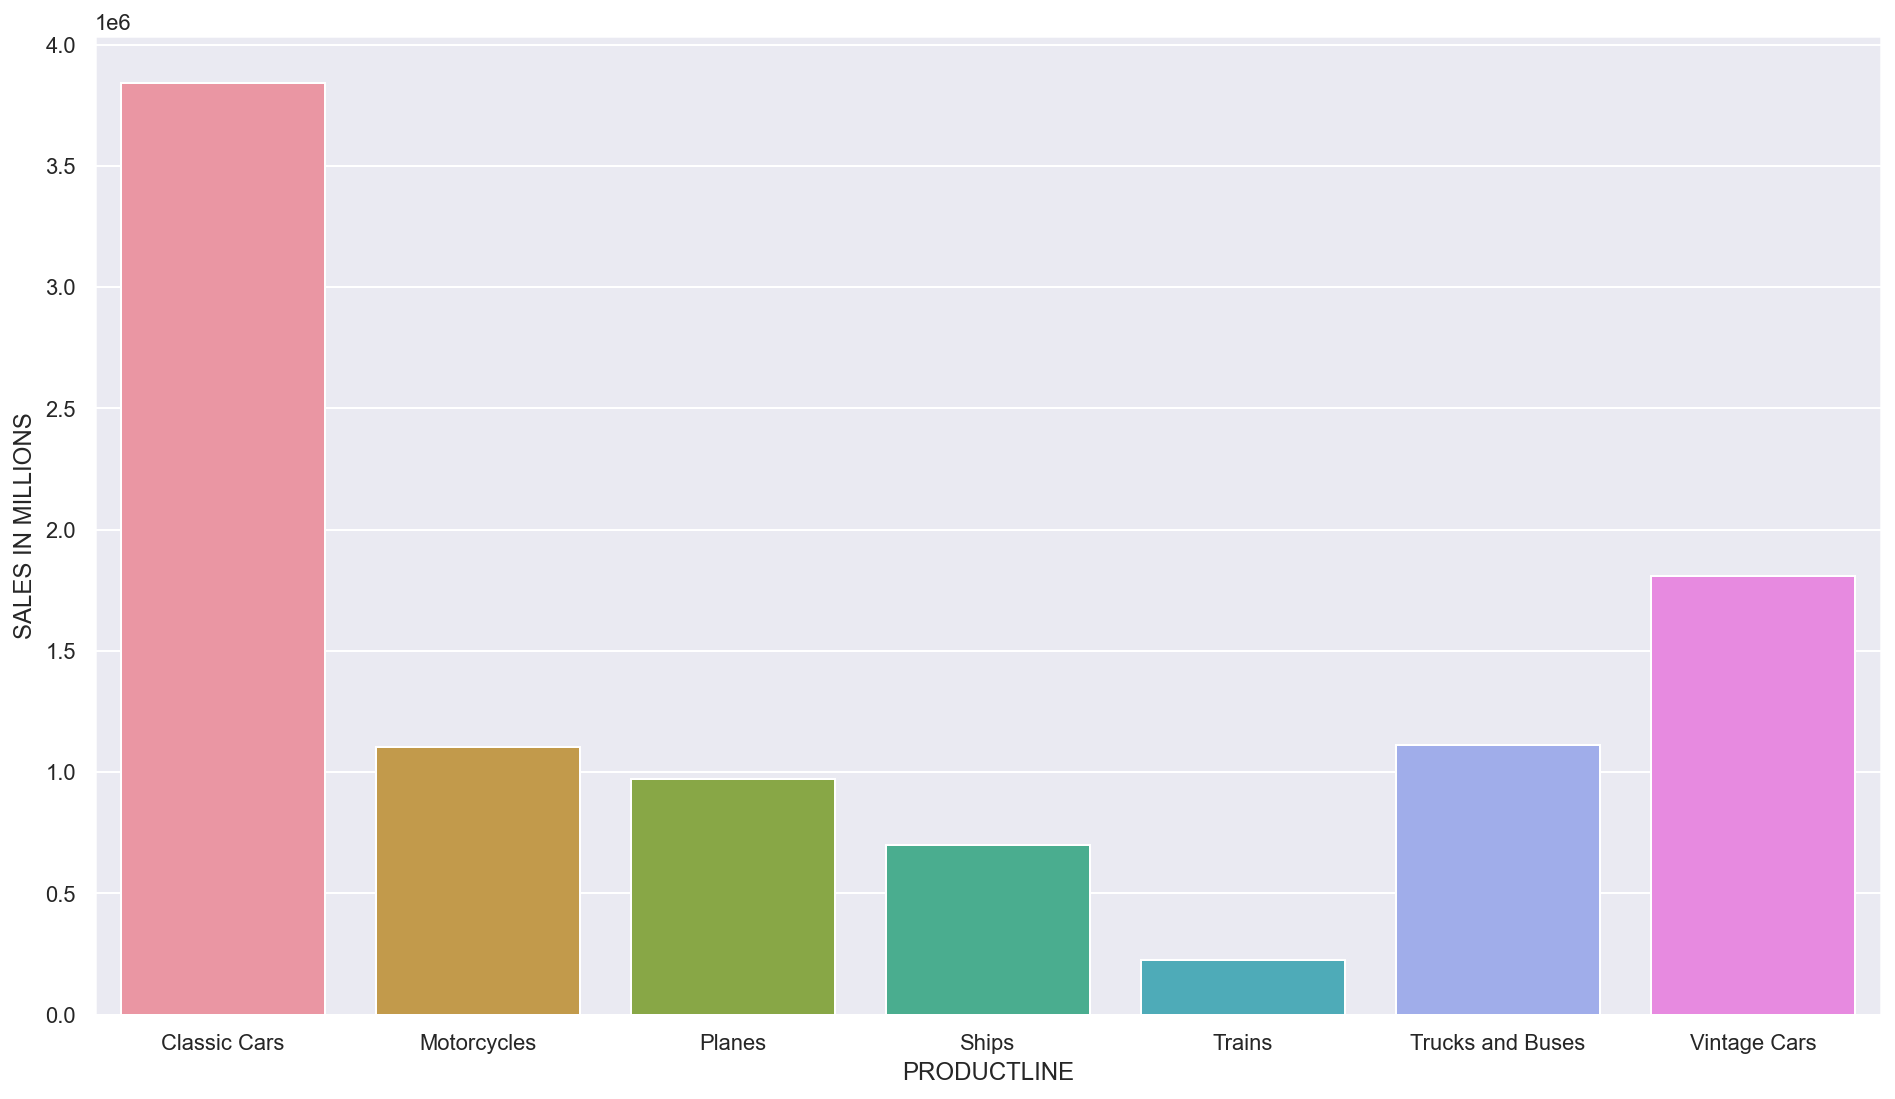

In [86]:
sns.barplot(df_prod.index, df_prod['SALES']);
plt.ylabel('SALES IN MILLIONS');

plt.savefig('prod_categ_sales_bar.jpg', bbox_inches='tight');

In [70]:
df3 = df2.copy()
df_prod_qtr = pd.DataFrame(df3[['PRODUCTLINE', 'SALES']].groupby(['PRODUCTLINE']).sum())
df_prod_qtr

SALES
PRODUCTLINE                 
Classic Cars      3842868.54
Motorcycles       1103512.19
Planes             969323.42
Ships              700039.22
Trains             226243.47
Trucks and Buses  1111559.19
Vintage Cars      1806675.68

In [88]:
df3

SALES  PRODUCTLINE  ORDERDATE  YEAR    MONTH QUARTER  \
0     2871.00  Motorcycles 2018-02-24  2018  2018-02  2018Q1   
1     2765.90  Motorcycles 2018-05-07  2018  2018-05  2018Q2   
2     3884.34  Motorcycles 2018-07-01  2018  2018-07  2018Q3   
3     3746.70  Motorcycles 2018-08-25  2018  2018-08  2018Q3   
4     3479.76  Motorcycles 2018-10-28  2018  2018-10  2018Q4   
...       ...          ...        ...   ...      ...     ...   
2742  2244.40        Ships 2019-12-02  2019  2019-12  2019Q4   
2743  3978.51        Ships 2020-01-31  2020  2020-01  2020Q1   
2744  5417.57        Ships 2020-03-01  2020  2020-03  2020Q1   
2745  2116.16        Ships 2020-03-28  2020  2020-03  2020Q1   
2746  3079.44        Ships 2020-05-06  2020  2020-05  2020Q2   

                       WEEK  
0     2018-02-19/2018-02-25  
1     2018-05-07/2018-05-13  
2     2018-06-25/2018-07-01  
3     2018-08-20/2018-08-26  
4     2018-10-22/2018-10-28  
...                     ...  
2742  2019-12-02/2019-12-08  
2743  2020-01-27/2020-02-02  
2744  2020-02-24/2020-03-01  
2745  2020-03-23/2020-03-29  
2746  2020-05-04/2020-05-10  

[2747 rows x 7 columns]

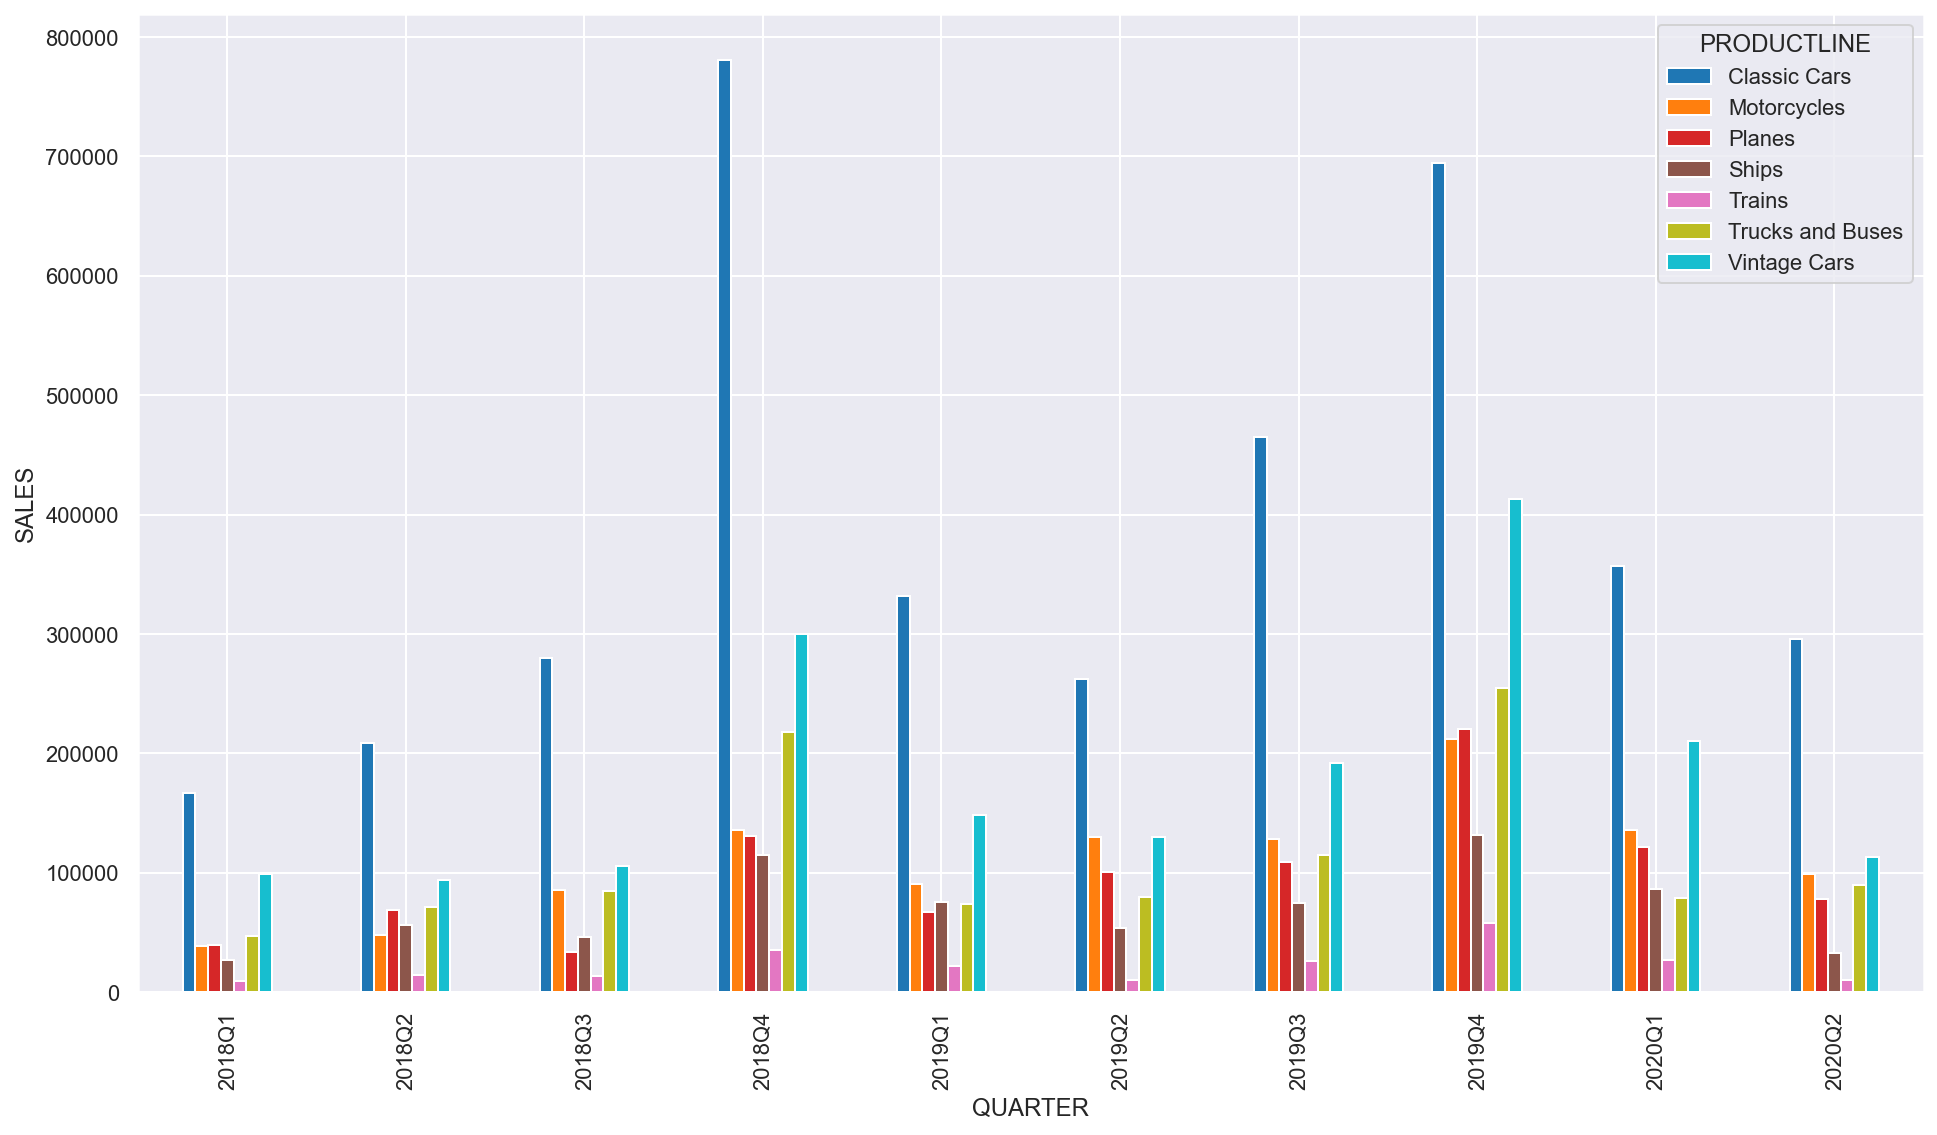

In [90]:
# fig, ax = plt.subplots(figsize=(15,7))
df3.groupby(['QUARTER', 'PRODUCTLINE']).sum()['SALES'].unstack().plot(cmap='tab10', kind='bar');
plt.ylabel('SALES');
plt.savefig('bar_qtr_product.jpg', bbox_inches='tight');

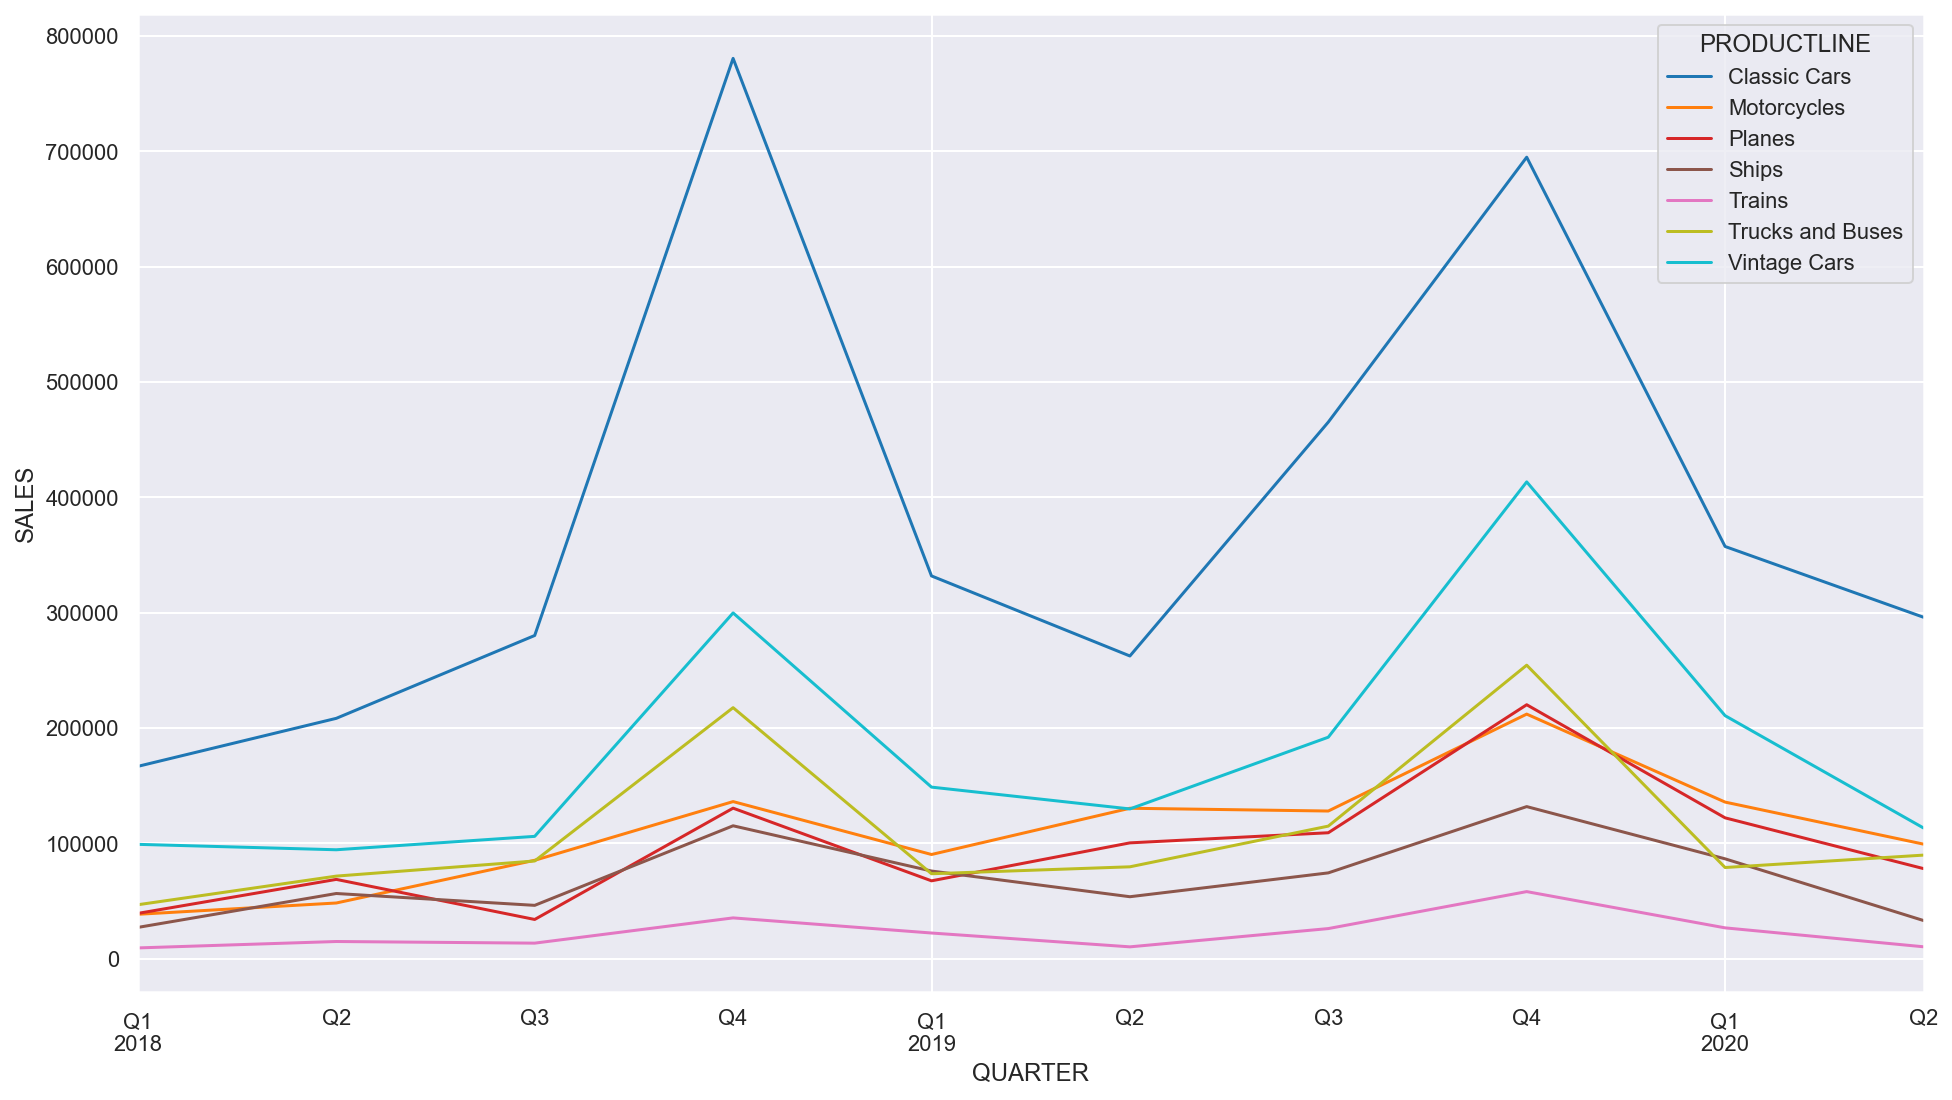

In [91]:
# fig, ax = plt.subplots(figsize=(15,7))
df3.groupby(['QUARTER', 'PRODUCTLINE']).sum()['SALES'].unstack().plot(cmap='tab10', kind='line');
plt.ylabel('SALES');
plt.savefig('line_qtr_product.jpg', bbox_inches='tight');

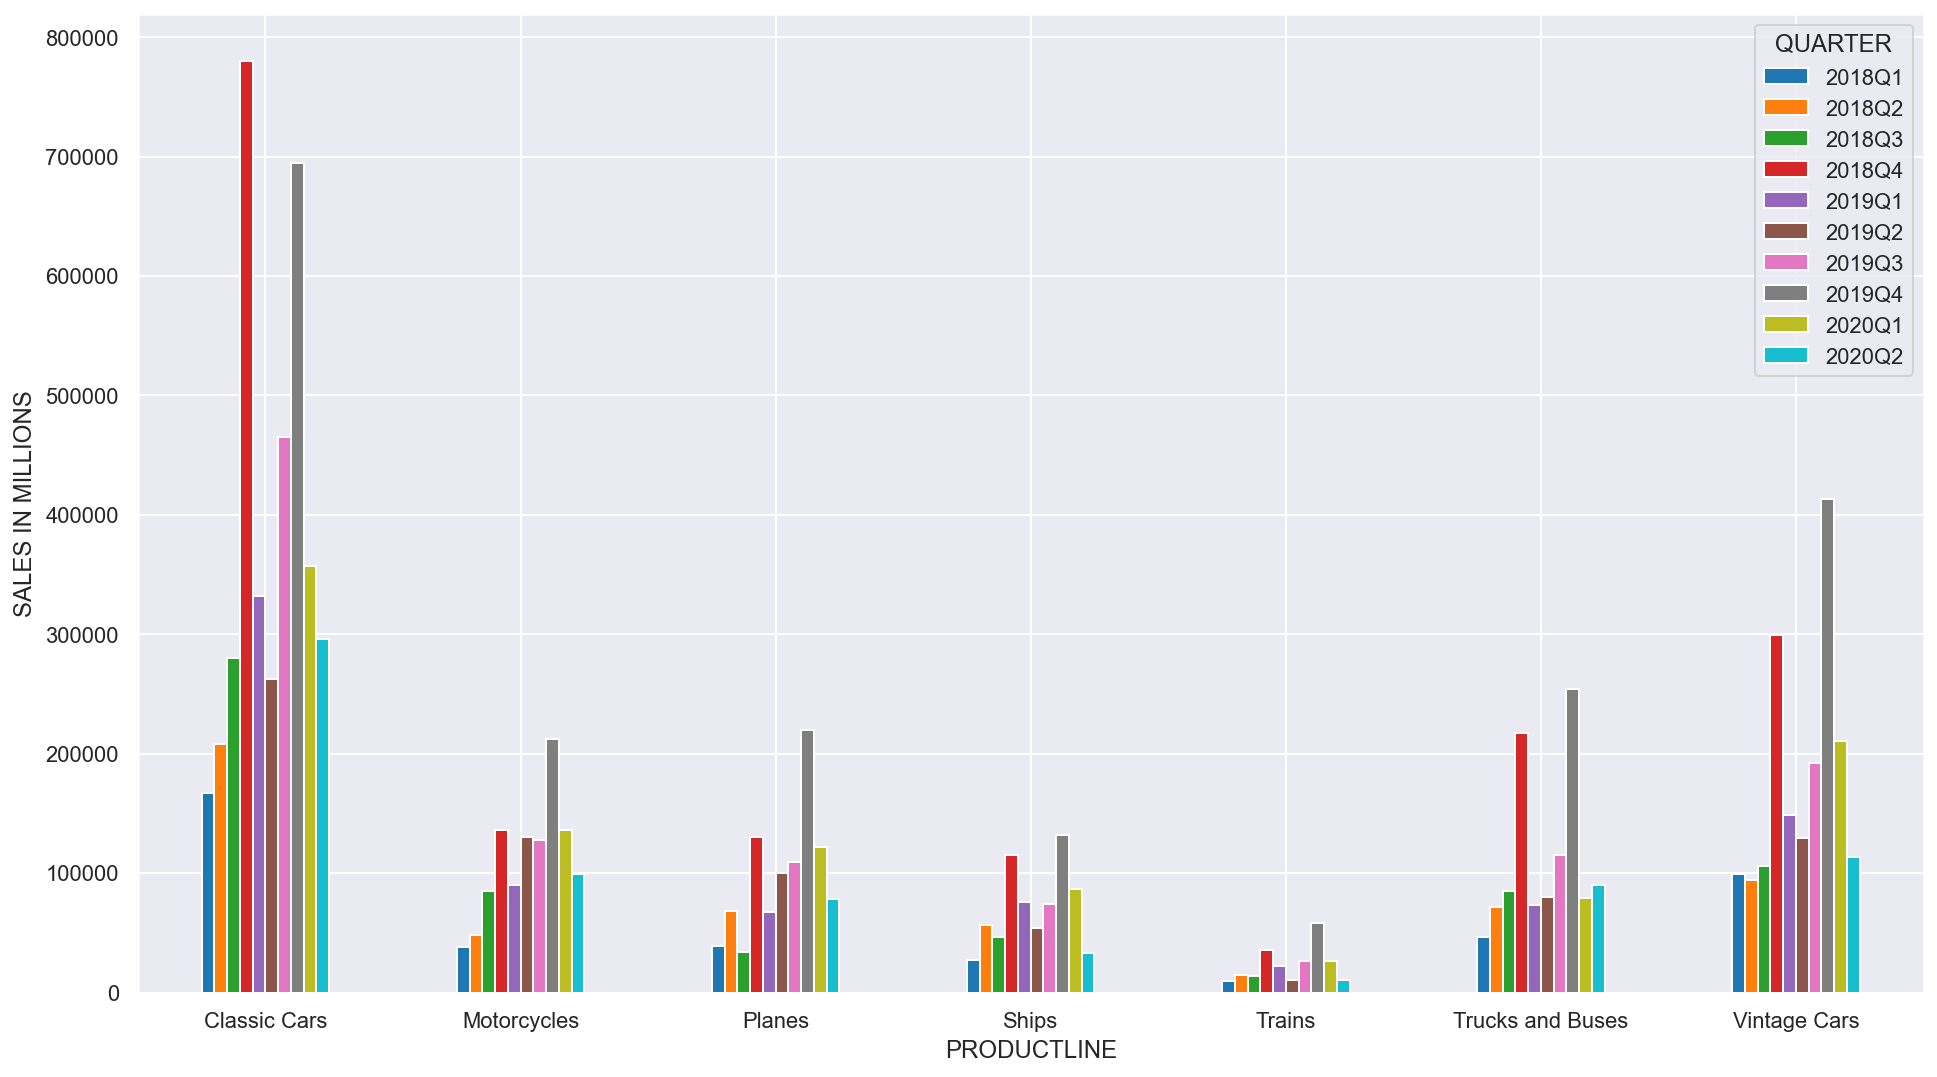

In [97]:
# fig, ax = plt.subplots(figsize=(15,7))
df3.groupby(['PRODUCTLINE', 'QUARTER']).sum()['SALES'].unstack().plot(cmap='tab10', kind='bar');
plt.ylabel('SALES IN MILLIONS');
plt.xticks(rotation=0);
plt.savefig('bar_product_qtr.jpg', bbox_inches='tight');